In [1]:
%cd '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts'

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


In [2]:
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime

from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pandas as pd
from dataLoader import *
from basic_data_methods import *
from skbio.stats.distance import permanova, DistanceMatrix, anosim
from skbio.stats.distance import mantel
from statsmodels.stats.multitest import multipletests
from matplotlib.collections import LineCollection
from Bio import Phylo
import re
from statistics import mode
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.lines as mlines

In [3]:
from skbio.diversity.alpha import ace, chao1, shannon, berger_parker_d, brillouin_d, dominance, doubles, enspie, fisher_alpha
from skbio.diversity.alpha import goods_coverage, heip_e, kempton_taylor_q, lladser_pe, margalef, mcintosh_d, mcintosh_e
from skbio.diversity.alpha import menhinick, observed_otus, osd, pielou_e, robbins, simpson, simpson_e, singles, strong

In [218]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [4]:
path_to_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

In [5]:
dl = dataLoader(pt_perc = {'metabs': .25, '16s': .1, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 50, '16s': 5, 'scfa': 0, 'toxin':0}, pt_tmpts = 1)

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
for key in dl.week.keys():
    print(key + ': ' + str(dl.week[key][0]['x'].shape[1]))

metabs: 760
16s: 237
scfa: 8
toxin: 3
metabs_16s: 997
metabs_scfa: 768
metabs_toxin: 763


# Table 1A - Demographics

In [54]:
targets = pd.Series(dl.targets_by_pt)
targets = targets.replace('Cleared','Non-recurrer')
targets = targets.replace('Recur', 'Recurrer')
demo_dict = {}
for feat in dl.demographics.columns.values:
    if len(np.unique(dl.demographics[feat]))<=4 or (dl.demographics[feat].dtypes!=int and dl.demographics[feat].dtypes!=float):
        for cat in np.unique(dl.demographics[feat]):
            N = np.sum((dl.demographics[feat]==cat)*(targets=='Non-recurrer'))
            c_re = np.sum((dl.demographics[feat]==cat)*(targets=='Recurrer'))
            demo_dict[(feat,cat)] = {'N_nonRec': N, 'N_Rec': c_re}
    else:
        demo_dict[(feat,'Mean')] = {'N': np.mean(dl.demographics[feat])}
        demo_dict[(feat,'STD')] = {'N': np.std(dl.demographics[feat])}
        demo_dict[(feat,'Median')] = {'N': np.median(dl.demographics[feat])}
        demo_dict[(feat,'Range')] = {'N': (np.min(dl.demographics[feat]),np.max(dl.demographics[feat]))}

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expre

In [55]:
pd.DataFrame(demo_dict).T

N N_nonRec N_Rec
Age            Mean                                 57.943396      NaN   NaN
               STD                                  15.392249      NaN   NaN
               Median                                    57.0      NaN   NaN
               Range                                 (22, 93)      NaN   NaN
Sex            0                                          NaN     13.0   5.0
               1                                          NaN     21.0  14.0
Race           0                                          NaN      7.0   1.0
               1                                          NaN      2.0   3.0
               2                                          NaN     25.0  15.0
BMI            Mean                                 28.918258      NaN   NaN
               STD                                   8.494553      NaN   NaN
               Median                               26.293698      NaN   NaN
               Range   (19.356873636183295, 66.6622240733028)      NaN   NaN
Smoking status 0                                          NaN     18.0  13.0
               1                                          NaN     15.0   5.0
               2                                          NaN      1.0   1.0
Prior PPI use  0                                          NaN     17.0  11.0
               1                                          NaN     17.0   8.0
Drug           0                                          NaN     27.0  11.0
               1                                          NaN      7.0   8.0
Toxin +        0                                          NaN     17.0   4.0
               1                                          NaN     17.0  15.0

# Table 1B - # Recurrers at each timepoint

In [87]:
rc_dict = {}
for week in dl.week['metabs'].keys():
    rc_dict[week]={}
    targets = dl.week['metabs'][week]['y']
    rc_dict[week]['Recurrers'] = np.sum(targets=='Recurrer')
    rc_dict[week]['Non-Recurrers'] = np.sum(targets=='Non-recurrer')
pd.DataFrame(rc_dict).T.to_csv(path_to_save + 'Fig1/outcome_table.csv')

# Fig 1A - Entropy 

In [377]:
entropy_df = {i: pd.DataFrame({'Week ' + str(i): [chao1(dl.week_raw['16s'][i]['x'].loc[k,:]) 
                                                  for k in dl.week_raw['16s'][i]['x'].index.values], 
                               'Outcome': dl.week_raw['16s'][i]['y']}) 
              for i in dl.week_raw['16s'].keys()}
bins = [i for i in entropy_df.keys() if isinstance(i, int)]

entropy_f = {}
for b in bins:
    
    b1 = entropy_df[b]
    if b +.5 not in entropy_df.keys():
        entropy_f[b] = entropy_df[b]
        continue
    b2 = entropy_df[b + .5]
    ix_sim = list(set(b1.index.values).intersection(set(b2.index.values)))
    ix_all = np.concatenate((b1.index.values,b2.index.values))
    df = pd.DataFrame(index = np.unique(ix_all), columns = ['Week ' + str(b), 'Outcome'])
    df['Outcome'][b1.index.values] = b1['Outcome']
    df['Outcome'][b2.index.values] = b2['Outcome']
    
    df['Week '+ str(b)][b1.index.values] = b1['Week ' + str(b)]
    df['Week '+ str(b)][b2.index.values] = b2['Week ' + str(b+0.5)]
    
    b_together = (b1['Week ' + str(b)][ix_sim] + b2['Week ' + str(b+0.5)][ix_sim])/2
    df['Week '+ str(b)][ix_sim] = b_together
    
    entropy_f[b] = df

In [378]:
# Get change in entropy
tmpts_to_test = [0,1,2,3,4]
e_dict = entropy_f.copy()

pts_over_time = {(w, w+1): list(set(e_dict[w].index.values).intersection(
    set(e_dict[w+1].index.values))) for w in tmpts_to_test[:-1]}
delta_entropy = {}
for k in pts_over_time.keys():
    d_e = (e_dict[k[1]]['Week '+ str(k[1])].loc[pts_over_time[k]] - 
                 e_dict[k[0]]['Week '+ str(k[0])].loc[pts_over_time[k]])/(k[1] - k[0])
    out_df = pd.concat([e_dict[k[0]]['Outcome'], 
                          e_dict[k[1]]['Outcome']])
    out_df = out_df[~out_df.index.duplicated()].loc[pts_over_time[k]]
    delta_entropy[k] = pd.DataFrame({'Week ' + str(k): d_e, 'Outcome': out_df})

tmpts = list(delta_entropy.keys())[:-1]
pval = {}
h_dict = {}
# outcome= ['Recurrer','Non-recurrer']
for tmpt in tmpts:
    if tmpt == (0,1):
        hyp = 'two-sided'
    else:
        hyp = 'less'
    entropy = delta_entropy[tmpt]
    entropy_re = entropy.loc[entropy['Outcome']== 'Recurrer']
    entropy_non = entropy.loc[entropy['Outcome'] == 'Non-recurrer']
    try:
        _, pval[tmpt] = st.mannwhitneyu(entropy_re['Week ' + str(tmpt)], 
                                                  entropy_non['Week ' + str(tmpt)],
                                                 alternative =  hyp)
        h_dict[tmpt] = hyp
    except:
        continue
pval_corr = {t: p for t, p in zip(tmpts, multipletests(list(pval.values()), alpha = 0.05, method = 'fdr_bh')[1])}
df_cl_v_re = pd.DataFrame({'Uncorrected': pval, 'Corrected': pval_corr, 'Alternative': h_dict})
pd.DataFrame(df_cl_v_re).to_csv(path_to_save + 'Fig3/entropy/delta_entropy_mann_whit_no_binning.csv')

In [379]:
for key in entropy_df.keys():
    pd.DataFrame(entropy_df[key]).to_csv(path_to_save + 'Fig3/entropy/entropy_week' + str(key) + '_data.csv')

In [388]:
def set_font_sizes(figsize, ftype_dict = {'font': 8, 'axes_title': 16, 'ax5s_label': 12, 
                                          'xtick_label': 10, 'ytick_label': 10, 'legend': 10, 'figure_title': 18}):
    default_a = (6*8)/7
    if figsize == None:
        area = default_a
    else:
        area = figsize[0]*figsize[1]/((figsize[0] + figsize[1])/2)
    for ftype, factor in ftype_dict.items():
        size = factor*area/default_a
        if 'title' in ftype:
            plt.rc(ftype.split('_')[0], titlesize=size)
        elif 'label' in ftype:
            plt.rc(ftype.split('_')[0], labelsize=size)
        elif 'legend' in ftype:
            plt.rc(ftype.split('_')[0], fontsize=size)   
        else:
            plt.rc(ftype.split('_')[0], size=size)
        print(ftype + ': ' + str(size))

In [380]:
def entropy_over_time(entropy_df, tmpts = [0,1,2], use_ranksum = False, use_one_sided = True):
    pval = {}
    pvals = []
    for cl in ['Recurrer','Non-recurrer']:
        pval[cl] = {}
        for tix, tmpt in enumerate(tmpts[:-1]):
            entropy_1 = entropy_df[tmpt]
            entropy_2 = entropy_df[tmpt + 1]
            entropy_1 = entropy_1.loc[entropy_1['Outcome'] == cl]
            entropy_2 = entropy_2.loc[entropy_2['Outcome'] == cl]
            ix_sim = set(entropy_1.index.values).intersection(set(entropy_2.index.values))
            if use_one_sided:
                if tmpt == 0:
                    alt = 'greater'
                else:
                    alt = 'less'
            else:
                alt = 'two-sided'
            try:
                if use_ranksum:
                    _, p = st.wilcoxon(entropy_1.loc[ix_sim]['Week ' + str(tmpt)], 
                                                              entropy_2.loc[ix_sim]['Week ' + str(tmpt+1)],
                                                             alternative = alt)
                    tname = 'wilcoxnon_ranksum'
                else:
                    _, p = st.mannwhitneyu(entropy_1['Week ' + str(tmpt)],  entropy_2['Week ' + str(tmpt+1)],
                                                             alternative = alt)   
                    tname = 'mannwhitney'

                pval[cl][(tmpt, tmpt+1)] = p
                pvals.append(p)
            except:
                continue
    pval_corr = {}
    pvals_corr = multipletests(pvals, alpha = 0.05, method = 'fdr_bh')[1]
    it = 0
    for cl in ['Recurrer','Non-recurrer']:
        pval_corr[cl] = {}
        for tmpt in tmpts[:-1]:
            pval_corr[cl][(tmpt, tmpt+1)] = pvals_corr[it]
            it += 1
    # p_df = pd.DataFrame(pval, index = [0]).T
    # p_df.to_csv('paper_figs/entropy_ttest.csv')
    dictionary = {'Uncorrected': pval, 'Corrected': pval_corr}
    reform = {(outerKey, innerKey): values for outerKey, 
              innerDict in dictionary.items() for innerKey, values in innerDict.items()}
    df_over_time = pd.DataFrame(reform)
    pd.DataFrame(reform).to_csv(path_to_save + 'Fig3/entropy/intra_entropy_' + tname + '_' + alt + '.csv')
    return df_over_time

In [381]:
def entropy_bw_grps(entropy_df, tmpts = [0,1,2], use_one_sided = True, 
                   path_to_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'):
    pval = {}
    outcome= ['Recurrer','Non-recurrer']
    for tmpt in tmpts:
        entropy = entropy_df[tmpt]
        entropy_1 = entropy.loc[entropy['Outcome'] == outcome[0]]
        entropy_2 = entropy.loc[entropy['Outcome'] == outcome[1]]

        if use_one_sided:
            if tmpt == 0:
                alt = 'two-sided'
            else:
                alt = 'less'
        else:
            alt = 'two-sided'

        try:
            _, pval[tmpt] = st.mannwhitneyu(entropy_1['Week ' + str(tmpt)], 
                                                      entropy_2['Week ' + str(tmpt)],
                                                     alternative = alt)
        except:
            continue
    pval_corr = {t: p for t, p in zip(tmpts, multipletests(list(pval.values()), alpha = 0.05, method = 'fdr_bh')[1])}

    # p_df = pd.DataFrame(pval, index = [0]).T
    # p_df.to_csv('paper_figs/entropy_ttest.csv')
    df_cl_v_re = pd.DataFrame({'Uncorrected': pval, 'Corrected': pval_corr})
    pd.DataFrame({'Uncorrected': pval, 'Corrected': pval_corr}).to_csv(path_to_save +
                                                                       'Fig3/entropy/inter_entropy_mann_whit_' + 
                                                                       alt + '.csv')
    return df_cl_v_re

In [382]:
def get_panal_locs(ax):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    return (xmin,ymax + 0.1*(ymax-ymin))

In [384]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse, Rectangle

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, shapes, alphas=None):
        self.colors = colors
        self.shapes = shapes
        if alphas:
            self.alphas = alphas
        else:
            if isinstance(self.colors, list):
                self.alphas = [1]*len(self.colors)
            else:
                self.alphas = 1
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        handlebox.width = len(orig_handle.colors)*handlebox.height + handlebox.height*0.1*len(orig_handle.colors)
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            if orig_handle.shapes[i]=='s':
                patches.append(Rectangle([width/len(orig_handle.colors)*i + (handlebox.height*0.1)*i, 0],
                               height,
                               height, 
                               facecolor=c, 
                               alpha = orig_handle.alphas[i],
                               edgecolor='gray'))
            else:
                patches.append(Ellipse([(width/len(orig_handle.colors)*i) + width/len(orig_handle.colors)/2+ 
                                        (handlebox.height*0.1)*i, height/2],
                               height,
                               height, 
                               facecolor=c, 
                               alpha = orig_handle.alphas[i],
                               edgecolor='gray'))                

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

In [410]:
def plot_entropy_boxplots(entropy_f, fig, ax, fig_title = None, week_colors = None, cmap_name = 'tab20'):
    if 1 in entropy_f.keys():
        pts = entropy_f[1].index.values
        pts0 = entropy_f[0].index.values
        pts_full = np.concatenate((pts, pts0))
    else:
        pts_all = [entropy_f[ii].index.values for ii in entropy_f.keys()]
        pts_full = np.unique(np.concatenate(pts_all))
    # for cl in ['Non-recurrer','Recurrer']
    # for key, val in entropy_f.items():
    rec = 0
    n_rec = 0
    c_rec = []
    c_nrec = []
    c_rec_dict = {}

    if week_colors is None:
        colors = {}
        cmap = matplotlib.cm.get_cmap(cmap_name)
        i=0
        for ii,t in enumerate(entropy_f.keys()):
            for jj in ['Recurrer','Non-recurrer']:
                cv = cmap(i)
                colors[str(t) + jj] = cv
                i+=1
    else:
        colors = {}
        for ii,t in enumerate(entropy_f.keys()):
            for jj in ['Recurrer','Non-recurrer']:
                colors[str(t) + jj] = week_colors[jj]


    for key, val in entropy_f.items():
        cvec_r = colors[str(key) + 'Recurrer']
        cvec_nr = colors[str(key) + 'Non-recurrer']
    #         if np.round(key) != key:
    #             continue
        if (0,1) in entropy_f.keys():
            key_n = key[0]
        else:
            key_n = key
        box1 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Non-recurrer'], positions = [key_n-0.1], 
                         whis=[5, 95],showfliers=False)
        for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
            plt.setp(box1[element], color=cvec_nr, linewidth = 2, alpha = 0.75, zorder = -1)
#         plt.setp(box1['fliers'], color = False, linewidth = 0, alpha = 1, zorder = -1)
        box2 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Recurrer'], positions = [key_n+.1], 
                          whis=[5, 95],showfliers=False)
        for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
            plt.setp(box2[element], color=cvec_r, linewidth = 2, alpha = 0.75, zorder = -1)
                
    m1 = {}
    m2 = {}
    for pt in pts_full:
        keys = [key for key in entropy_f.keys() if pt in entropy_f[key].index.values]
        vals = [entropy_f[key]['Week ' + str(key)][pt] for key in keys]
        if 1 in entropy_f.keys():
            if pt in entropy_f[1].index.values:
                df_to_check = entropy_f[1]
            elif pt in entropy_f[0].index.values:
                df_to_check = entropy_f[0]
        else:
            pt_where = [i for i in range(len(pts_all)) if pt in pts_all[i]]
            df_to_check = entropy_f[list(entropy_f.keys())[pt_where[0]]]
            keys = [key[0] for key in keys]


        for key, val in zip(keys, vals):
            if df_to_check['Outcome'][pt] == 'Recurrer':
                cvec_r = colors[str(key) + 'Recurrer']
                c_rec_dict[pt] = keys
                c_rec.extend(keys)
                keys = np.array(keys)
        #             else:
        # #                 ax.plot(keys+.08, vals, '*',ms = 10,c = 'r', alpha = 0.1)
                ax.scatter(key+.08 + np.random.uniform(-1,1)*.05, val, marker='o',s = 20,
                           color = cvec_r,edgecolors= "black", alpha = 0.65)
            elif df_to_check['Outcome'][pt] == 'Non-recurrer':
                cvec_nr = colors[str(key) + 'Non-recurrer']
                c_nrec.extend(keys)
                keys = np.array(keys)
        #             else:
        #                 ax.plot(keys - .08, vals, '*',ms = 10,c = 'g', alpha = 0.1)
                ax.scatter(key-.08+ np.random.uniform(-1,1)*.05, val, marker='o',s = 20,
                           color = cvec_nr,edgecolors= "black", alpha = 0.65)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax])
    
    ax.grid( False, axis='x' )
    ax.grid( False, axis='x', which='minor' )


    if 1 in entropy_f.keys():
        ax.set_xticks([1,2,3,4])
        ax.set_xticks([0, 2.5], minor = True)
        ax.set_xticklabels(labels=['Week 1','Week 2', 'Week 3','Week 4'], 
                           #rotation = 10,  ha = 'center', 
                          minor = False)
        ax.set_xticklabels(labels = ['\nPre-Antibiotic Treatment','\nPost-Antibiotic Treatment'], 
                           minor = True)
    else:
        ax.set_xticks([1,2,3])
        ax.set_xticks([0, 2], minor = True)
        ax.set_xticklabels(labels=['Week 1 to Week 2','Week 2 to Week 3', 'Week 3 to Week 4'], 
                           #rotation = 10,  ha = 'center', 
                          minor = False)
        ax.set_xticklabels(labels = ['\nPre-Antibiotic Treatment to Week 1','\nPost-Antibiotic Treatment'], 
                           minor = True)

    ax.set_ylabel('Chao1 Index')
    if fig_title:
        ax.set_title(fig_title)

        
    markers = {'Non-recurrer':'o','Recurrer':'o'}
    h, l = [],[]
    keys = entropy_f.keys()
    if week_colors is None:
        for re in ['Recurrer', 'Non-recurrer']:
            h.append(MulticolorPatch([colors[str(key) + re] for key in keys], [markers[re] for key in keys]))
            l.append(re)

        fig.legend(h, l, 
                   handler_map={MulticolorPatch: MulticolorPatchHandler()})
    else:
        a1 = ax.scatter([], [], marker='o',s = 50,
                           color = week_colors['Recurrer'],edgecolors= "black", alpha = 0.65)
        a2 = ax.scatter([], [], marker='o',s = 50,
                           color = week_colors['Non-recurrer'],edgecolors= "black", alpha = 0.65)

        ax.legend([a1, a2],['Recurrer','Non-recurrer'], loc = 'upper right')
    return fig, ax

font: 11.000000000000002
axes_title: 12.0
axes_label: 12.0
xtick_label: 12.0
ytick_label: 10.0
legend: 11.000000000000002
figure_title: 12.0


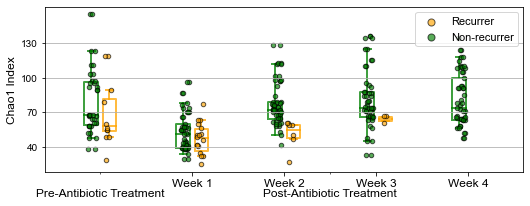

In [530]:
fig, ax_entropy = plt.subplots(figsize=(7.5,3))


set_font_sizes(None, {'font': 11, 'axes_title': 12, 'axes_label': 12, 
                                          'xtick_label': 12, 'ytick_label': 10, 
                         'legend': 11, 'figure_title': 12})

out_dict = {}
tmpt_dict = {}
# PCA
fig, ax_entropy = plot_entropy_boxplots(entropy_f, fig, ax_entropy, 
                                        fig_title = None, 
                                        week_colors = {'Recurrer':'orange','Non-recurrer':'g'})
ent_over_time = entropy_over_time(entropy_f)
ent_bw_grps = entropy_bw_grps(entropy_f)

ax_entropy.grid(axis='y')
ax_entropy.set_yticks([40,70,100,130])
fig.tight_layout()
plt.savefig(path_to_save + 'Fig3/entropy.pdf')
plt.show()

In [535]:
def plot_PCA(finalDf, variance, targets, path = 'pca', target_labels=None, fig_title='', 
             colors=None, fig = None, ax = None, cmap_name = 'tab20', sizes = None, alphas = None, 
            markers = None, legend = False):
    if fig == None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        save_fig = True
    else:
        save_fig = False
    ax.set_xlabel('PC 1, variance explaned= ' +
                  str(np.round(variance[0]*100, 3)) + '%')
    ax.set_ylabel('PC 2, variance explaned= ' +
                  str(np.round(variance[1]*100, 3)) + '%')
    ax.set_title(fig_title)
    
    if sizes is None:
        sizes = {'Recurrer':30, 'Non-recurrer':20}
    if alphas is None:
        alphas = {'Recurrer':0.8, 'Non-recurrer':0.65}
    if markers is None:
        markers = {'Recurrer': 's', 'Non-recurrer': 'o'}

    if len(targets) == 2 and hasattr(targets[0], "__len__"):
        tlabs = [np.unique(targs).tolist() for targs in targets]
        if len(tlabs[0])==2:
            tlabs[0].sort(reverse = True)
            a,b = (0,1)
        else:
            tlabs[1].sort(reverse = True)
            a, b = (1,0)

        if colors is None:
            colors = {}
            cmap = matplotlib.cm.get_cmap(cmap_name)
            i=0
            for ii in tlabs[b]:
                colors[ii] = {}
                for jj in tlabs[a]:
                    cv = cmap(i+10)
                    colors[ii][jj] = cv
                    i+=1

        all_targs = np.concatenate([list(zip(tlabs[a],x)) for x in itertools.permutations(tlabs[b],len(tlabs[a]))])
        lines = {}
        lines[a] = {}
        lines[b] = {}
        for targ in all_targs:
            indicesToKeep1 = np.where(targets[0] == targ[a])[0]
            # if targ[0] not in lines.keys():
            #     lines[targ[0]] = {}
            indicesToKeep2 = np.where(targets[1] == targ[b])[0]
            ix_combo = list(set(indicesToKeep1).intersection(indicesToKeep2))
            # recur/cleared will always be targ[0]
            # if recur/cleared are first, want recur/cleared to be colors
            # otherwise, want weeks to be colors & recur/cleared to be markers

            # if Recur/cleared is the second label OR if weeks is the second label
            # if targ[b] in tlabs[1]:
                # Condition met for whichever labels we want to be markers
            line = ax.scatter(finalDf.iloc[ix_combo]['PC1'],
                                  finalDf.iloc[ix_combo]['PC2'], 
                              color = colors[targ[b]][targ[a]], s=sizes[targ[a]], alpha = alphas[targ[a]],
                             marker = markers[targ[a]],edgecolors= "gray")


        h=[]
        l=[]
        for k in tlabs[a]:
            h.append(MulticolorPatch([colors[str(key)][k] for key in tlabs[b]], [markers[k] for key in tlabs[b]]))
            l.append(k)


#         leg1 = fig.legend(h, l, 
#                    handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', bbox_to_anchor=(1.2, .8),
#                          prop={'size': 10})
        legend_1 = (h,l)

        h=[]
        l=[]
        for k in tlabs[b]:
            h.append(MulticolorPatch([colors[k][key] for key in tlabs[a]], [markers[key] for key in tlabs[a]]))
            if k=='0':
                k= 'Pre-Antibiotics'
            elif float(k)<4:
                k = 'Week ' + k 
                #+ ' to ' + str(float(k)+0.5)
            else:
                k = 'Week ' + k
            l.append(k)
        legend_2 = (h,l)
#         leg2 = fig.legend(h, l, 
#            handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', bbox_to_anchor=(1.18, 0.55),
#                    prop={'size': 10})
#         ax.add_artist(leg1)
        
    else:
        legend_2 = None
        legend_1 = None
        tlabs = np.unique(targets)
        if colors is None:
            colors = {}
            cmap = matplotlib.cm.get_cmap(cmap_name)
            for ii,t in enumerate(tlabs):
                colors[t] = cmap(ii)
        for target, color in zip(tlabs, colors):
            indicesToKeep = np.array(targets == target)
            ax.scatter(finalDf.loc[indicesToKeep, 'PC1'],
                       finalDf.loc[indicesToKeep, 'PC2'], c=colors[color], s=25)
            
        if legend:
            if target_labels is None:
                ax.legend(tlabs, prop={'size': 10})
            else:
                ax.legend(target_labels, prop={'size': 10})
    if save_fig:
        plt.savefig(path + '.pdf')
    else:
        return fig, ax, legend_2, legend_1

font: 11.000000000000002
axes_title: 12.0
axes_label: 12.0
xtick_label: 12.0
ytick_label: 10.0
legend: 11.000000000000002
figure_title: 12.0
(184, 184)
(180, 180)


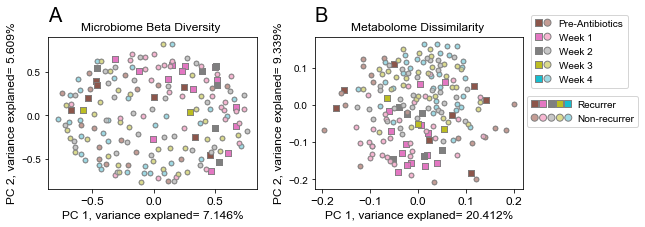

In [536]:
fig, (ax_otus, ax_metabs) = plt.subplots(1,2,figsize=(7.5,7.5/2.25))

out_dict = {}
tmpt_dict = {}
# PCA
set_font_sizes(None, {'font': 11, 'axes_title': 12, 'axes_label': 12, 
                                          'xtick_label': 12, 'ytick_label': 10, 
                         'legend': 11, 'figure_title': 12})

metabs = pd.DataFrame(np.vstack([dl.week_raw['metabs'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl.week_raw['metabs'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                      columns = dl.week_raw['metabs'][0]['x'].columns.values)
met_y = np.concatenate([dl.week_raw['metabs'][i]['y'] for i in [0,1,2,3,4]])
met_y_tmpts = np.array([x.split('-')[1] for x in metabs.index.values]).astype(float).astype(int).astype(str)
pca_dF, variances, d1 = pcoa_custom(metabs, metric='spearman', metric_mds = True)
fig, ax_metabs, l1,l2 = plot_PCA(pca_dF, variances, [met_y, met_y_tmpts], path='paper_figs/pca/metabs_sp', 
                          fig_title='Metabolome Dissimilarity ',target_labels=None,
                           fig = fig, ax = ax_metabs, legend = True)


counts = pd.DataFrame(np.vstack([dl.week_raw['16s'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl.week_raw['16s'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                          columns = dl.week_raw['16s'][0]['x'].columns.values)
prop_y = np.concatenate([dl.week_raw['16s'][i]['y'] for i in [0,1,2,3,4]])
prop_y_tmpts = np.array([x.split('-')[1] for x in counts.index.values]).astype(float).astype(int).astype(str)
pca_dF, variances, d_otus = pcoa_custom(counts, metric='braycurtis', metric_mds = True)
fig, ax_otus, l1, l2 = plot_PCA(pca_dF, variances, [prop_y, prop_y_tmpts], path='paper_figs/pca/otus',target_labels=
                         None,
         fig_title='Microbiome Beta Diversity ',
                        fig = fig, ax = ax_otus, legend = True)

leg1 = fig.legend(l1[0], l1[1], 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', bbox_to_anchor=(1.18, .75),
                 prop={'size': 10})

leg2 = fig.legend(l2[0], l2[1], 
   handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', bbox_to_anchor=(1.20, 0.5),
           prop={'size': 10})
# ax.add_artist(leg1)

xy_b = get_panal_locs(ax_otus)
ax_otus.annotate('A', xy = xy_b, annotation_clip = False, fontsize = 20)

xy_c = get_panal_locs(ax_metabs)
ax_metabs.annotate('B', xy = xy_c, annotation_clip = False, fontsize = 20)

fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.65)

fig.savefig(path_to_save + 'supplemental_figures/mds_only.pdf',bbox_extra_artists=([leg1,leg2]), bbox_inches = 'tight')
# plt.show()

In [698]:
pd.DataFrame(d1).to_csv(path_to_save + 'Fig3/dissimilarity/metabs_dist_mat.csv')
pd.DataFrame(d_otus).to_csv(path_to_save + 'Fig3/dissimilarity/otus_dist_mat.csv')

In [22]:
def get_masked_arr(d, ix):
    da = d[ix,:]
    db = da[:,ix]
    return db

In [40]:
np.fill_diagonal(d1, 0)
tmpt_dict = {}
out_dict = {}
for tmpt in ['0','1','2']:
    t_ix = np.where(met_y_tmpts==tmpt)[0]
    d_met_mask = get_masked_arr(d1, t_ix)

    if tmpt not in out_dict.keys():
        out_dict[tmpt] = {}
    try:
        out_dict[tmpt]["Metab, Spearman"] = permanova(DistanceMatrix(d_met_mask), met_y[t_ix])
    except:
        continue

    np.fill_diagonal(d_otus, 0)
    t_ix = np.where(prop_y_tmpts==tmpt)[0]
    d_otu_mask = get_masked_arr(d_otus, t_ix)
    out_dict[tmpt]["OTU, Bray-Curtis"] = permanova(DistanceMatrix(d_otu_mask), prop_y[t_ix])


for outcome in ['Recurrer','Non-recurrer']:
    if outcome not in tmpt_dict.keys():
        tmpt_dict[outcome]={}
        
    out_ix_met = np.where(met_y == outcome)[0]
    d2met = get_masked_arr(d1, out_ix_met)
    
    out_ix_otu = np.where(prop_y == outcome)[0]
    d2otu = get_masked_arr(d_otus, out_ix_otu) 
    
    for tmpt_pair in [('0','1'),('1','2')]:
        t_ix1 = np.concatenate([np.where(met_y_tmpts[out_ix_met]==tmpt_pair[0])[0], 
                               np.where(met_y_tmpts[out_ix_met]==tmpt_pair[1])[0]])
        d_met_mask = get_masked_arr(d2met, t_ix1)

        t_ix2 = np.concatenate([np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[0])[0], 
                               np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[1])[0]])
        d_otu_mask = get_masked_arr(d2otu, t_ix2)
        
        tmpt_dict[outcome]["Metab, Spearman, " + str(tmpt_pair)] = permanova(DistanceMatrix(d_met_mask), met_y_tmpts[out_ix_otu][t_ix1])
        tmpt_dict[outcome]["OTU, Bray-Curtis, " + str(tmpt_pair)] = permanova(DistanceMatrix(d_otu_mask), prop_y_tmpts[out_ix_otu][t_ix2])

pd.DataFrame(out_dict).T.to_csv(path_to_save + 'Fig3_results/dissimilarity/outcome_permanova_pvals.csv')
pd.DataFrame(tmpt_dict).T.to_csv(path_to_save + 'Fig3_results/dissimilarity/tmpt_permanova_pvals.csv')

In [29]:
np.fill_diagonal(d1, 0)
tmpt_dict = {}
out_dict = {}
for tmpt in ['0','1','2']:
    t_ix = np.where(met_y_tmpts==tmpt)[0]
    d_met_mask = get_masked_arr(d1, t_ix)

    if tmpt not in out_dict.keys():
        out_dict[tmpt] = {}
    try:
        out_dict[tmpt]["Metab, Spearman"] = anosim(DistanceMatrix(d_met_mask), met_y[t_ix])
    except:
        continue

    np.fill_diagonal(d_otus, 0)
    t_ix = np.where(prop_y_tmpts==tmpt)[0]
    d_otu_mask = get_masked_arr(d_otus, t_ix)
    out_dict[tmpt]["OTU, Bray-Curtis"] = anosim(DistanceMatrix(d_otu_mask), prop_y[t_ix])


for outcome in ['Recurrer','Non-recurrer']:
    if outcome not in tmpt_dict.keys():
        tmpt_dict[outcome]={}
        
    out_ix_met = np.where(met_y == outcome)[0]
    d2met = get_masked_arr(d1, out_ix_met)
    
    out_ix_otu = np.where(prop_y == outcome)[0]
    d2otu = get_masked_arr(d_otus, out_ix_otu) 
    
    for tmpt_pair in [('0','1'),('1','2')]:
        t_ix1 = np.concatenate([np.where(met_y_tmpts[out_ix_met]==tmpt_pair[0])[0], 
                               np.where(met_y_tmpts[out_ix_met]==tmpt_pair[1])[0]])
        d_met_mask = get_masked_arr(d2met, t_ix1)

        t_ix2 = np.concatenate([np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[0])[0], 
                               np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[1])[0]])
        d_otu_mask = get_masked_arr(d2otu, t_ix2)
        
        tmpt_dict[outcome]["Metab, Spearman, " + str(tmpt_pair)] = anosim(DistanceMatrix(d_met_mask), met_y_tmpts[out_ix_otu][t_ix1])
        tmpt_dict[outcome]["OTU, Bray-Curtis, " + str(tmpt_pair)] = anosim(DistanceMatrix(d_otu_mask), prop_y_tmpts[out_ix_otu][t_ix2])


pd.DataFrame(out_dict).T.to_csv(path_to_save + 'Fig3_results/dissimilarity/outcome_anosim_pvals.csv')
pd.DataFrame(tmpt_dict).T.to_csv(path_to_save + 'Fig3_results/dissimilarity/tmpt_anosim_pvals.csv')

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


# Univariate analysis

In [291]:
# Export for DEseq2 in R
weeks = [0,1,2]
plot = True

key = '16s'
for week in weeks:
#     if not isinstance(week, list):
    x = dl.week_filt[key][week]['x']
    y = (dl.week_filt[key][week]['y']=='Recurrer').astype('float')
#     else:
#         x,y,t = get_slope_data(dl.week_filt[key], week)
        
    if not os.path.isdir('inputs/DEseq2/'):
        os.mkdir('inputs/DEseq2/')
    x.to_csv(path_to_save +'scripts/inputs/DEseq2/counts_' + str(week).replace('.','-') + '.csv')
    y.to_csv(path_to_save +'scripts/inputs/DEseq2/col_' + str(week).replace('.','-') + '.csv')
    
# Export for DEseq2 in R
weeks = [(0,1),(1,2)]
key = '16s'
for outcome in ['Recurrer', 'Non-recurrer']:
    for week_pair in weeks:
        col0 = dl.week_filt[key][week_pair[0]]['x'].columns.values
        col1 = dl.week_filt[key][week_pair[1]]['x'].columns.values
        col_all = np.unique(np.concatenate([col0, col1]))
        ix0, ix1 = dl.week_filt[key][week_pair[0]]['x'].index.values, dl.week_filt[key][week_pair[1]]['x'].index.values
        
        x0, y0 = dl.keys[key]['data'][col_all].loc[ix0], dl.week_filt[key][week_pair[0]]['y']
        x1, y1 = dl.keys[key]['data'][col_all].loc[ix1], dl.week_filt[key][week_pair[1]]['y']
        x0 = x0.loc[y0.values == outcome]
        x1 = x1.loc[y1.values == outcome]
        x = pd.concat([x0, x1])
        y = [week_pair[0]]*x0.shape[0] + [week_pair[1]]*x1.shape[0]
        y = pd.Series((np.array(y)==week_pair[1]).astype('float'), index = x.index.values)
        if not os.path.isdir('inputs/DEseq2/'):
            os.mkdir('inputs/DEseq2/')
        x.to_csv(path_to_save +'scripts/inputs/DEseq2/counts_' + outcome +str(week_pair[0]) + '_' + str(week_pair[1]) + '.csv')
        y.to_csv(path_to_save +'scripts/inputs/DEseq2/col_' + outcome + str(week_pair[0]) + '_' + str(week_pair[1]) + '.csv')

In [293]:
# After performing DEseq2 in R

weeks = [0,1,2]
plot = False

key = '16s'
path_deseq2 = path_to_save + 'univariate_analysis/16s/deseq2/'
for file in os.listdir(path_deseq2):
    if file == '.DS_Store':
        continue
    week = file.split('res')[-1].split('.')[0]
    df_r = pd.read_csv(path_deseq2 + file, index_col = 0)
    df_sorted = df_r.sort_values(by = 'padj')
    taxa = return_taxa_names(df_sorted.OTU)
    df_sorted.insert(1, "Taxa", taxa, allow_duplicates=True)
    
    df_sorted.insert(2,"Direction", np.zeros(df_sorted.shape[0]).astype(str), True)
    
    if '_' in file:
        # Higher in cleared group (0) or first week
        df_sorted["Direction"].loc[df_sorted["log2fold"]<0] = 'Higher in week ' + file.split('_')[0].split('rer')[1]

        # Higher in recurred group (1) or second week
        df_sorted["Direction"].loc[df_sorted["log2fold"]>0] = 'Higher in week ' + file.split('_')[1].split('.')[0]
    else:
        # Higher in cleared group (0) or first week
        df_sorted["Direction"].loc[df_sorted["log2fold"]<0] = 'Decreased Risk'

        # Higher in recurred group (1) or second week
        df_sorted["Direction"].loc[df_sorted["log2fold"]>0] = 'Increased Risk'
    
    df_sorted = df_sorted.set_index("OTU")
    if plot:
        for metab in df_sorted.index.values:
            if df_sorted['padj'][metab] < .1:
                plot_metab_over_time(metab, df_sorted['padj'][metab], dl.keys[key], path_to_save + 'univariate_analysis/' + 
                                     key + '/' + str(week) + '_deseq2_')
    df_sorted.to_csv(path_to_save+'univariate_analysis/' + key + '/deseq2_' + key + str(week) + '.csv')
    plt.figure()
    plt.hist(df_sorted['padj'], bins = np.arange(0,1.05,.05))
    plt.xlabel('p-values')
    plt.ylabel('Frequency')
    plt.title(key + ', week ' + str(week))
    plt.savefig(path_to_save+'univariate_analysis/' + key + '/deseq2_' + key + str(week) + '.pdf')
    plt.close()
    

KeyboardInterrupt: 

In [27]:
key = 'toxin'
week = 1
x, targets = dl.week[key][week]['x'], dl.week[key][week]['y']

if isinstance(targets[0], str):
    targets = (np.array(targets) == 'Recurrer').astype('float')
else:
    targets = np.array(targets)

In [28]:
i = 2
if len(np.unique(x.iloc[:,i]))==2:
    xcat = x.iloc[:,i]
    vals = np.unique(xcat)
    xcat = xcat.replace(np.min(vals),0)
    xcat = xcat.replace(np.max(vals),1)
    prior = np.sum(targets==1)/len(targets)
    f0 = [np.sum(xcat==0)*prior, np.sum(xcat==1)*prior]
    f1 = [np.sum((xcat==0)*(targets==1)), np.sum((xcat==1)*(targets==1))]
    chisq, p = st.chisquare(f1, f0)
    if f1[1]<f0[1]:
        s = -1
    else:
        s = 1

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [49]:
def univariate_w_chi2(x, targets, method = 'ranksum', cutoff=.05):
    if isinstance(targets[0], str):
        targets = (np.array(targets) == 'Recurrer').astype('float')
    else:
        targets = np.array(targets)
    pval = []
    teststat = []
    methods = []
    direction = []
    for i in range(x.shape[1]):

        if len(np.unique(x.iloc[:,i]))<=3 or (x.iloc[:,i].dtypes!=int and x.iloc[:,i].dtypes!=float):
            xcat = x.iloc[:,i]
            vals = np.unique(xcat)
            tab = pd.crosstab(index = xcat, columns = targets)
            if tab.shape[0]==1:
                p = 1
                s = 1
                met_out = 'fisher exact'
                direction.append(0)
            elif len(np.unique(x.iloc[:,i]))>2:
                f1 = tab[1].tolist()
                prior = np.sum(targets==1)/len(targets)
                f0 = [np.sum(xcat==xc)*prior for xc in np.unique(xcat)]
                s, p = st.chisquare(f1, f0)
                dd = []
                for i in np.arange(len(f1)):
                    if f1[i]<f0[i]:
                        dd.append(-1)
                    elif f1[i]>f0[i]:
                        dd.append(1)
                    else:
                        dd.append(0)
                direction.append(dd)
                met_out = 'chi-squared'
            elif len(np.unique(x.iloc[:,i]))==2:
                s, p = st.fisher_exact(tab)
                if s < 1:
                    direction.append(-1)
                elif s > 1:
                    direction.append(1)
                else:
                    direction.append(0)
                met_out = 'fisher-exact'
        else:
            met_out = method
            xin = np.array(x)[:, i]
            X = xin[targets == 1]
            Y = xin[targets == 0]
            # xin1 = (xin - np.min(xin,0))/(np.max(xin,0)-np.min(xin,0))
            if met_out == 'ranksum':
                s, p = st.ranksums(X, Y)
            elif met_out == 'kruskal':
                try:
                    s, p = st.kruskal(X,Y)
                except:
                    p = 1
            elif met_out == 'ttest':
                s, p = st.ttest_ind(X,Y)

            if s < 0:
                direction.append(-1)
            elif s > 0:
                direction.append(1)
            else:
                direction.append(0)
        pval.append(p)
        teststat.append(s)
        methods.append(met_out)

    pval = np.array(pval)
    pval[np.isnan(pval)] = 1
    # corrected, alpha = bh_corr(np.array(pval), .05)

    reject, corrected, a1, a2 = multipletests(pval, alpha=.05, method='fdr_bh')
    df = pd.DataFrame(np.vstack((pval, corrected, teststat, direction, methods)).T, columns=[
        'P_Val', 'BH corrected', 'test statistic','direction','method'], index=x.columns.values)
    return df.sort_values('P_Val', ascending=True)

In [36]:
# Univariate analysis for demographics
targets = dl.keys['metabs']['targets_by_pt']
x = dl.demographics
xx = dl.demographics[['Age','Sex','Race','BMI','Smoking status']]
df_out = univariate_w_chi2(xx, targets)
df_out.to_csv(path_to_save + 'Tables/demographics.csv')

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [39]:
# Univariate analysis for demographics
targets = dl.keys['metabs']['targets_by_pt']
x = dl.clinical
df_out = univariate_w_chi2(x, targets)
df_out.to_csv(path_to_save + 'Tables/clinical.csv')

In [50]:
# Univariate analysis for metabolites and SCFAs
weeks = [0,1,2,[1,1.5,2]]
week_pairs = [(0,1),(1,2)]
plot = False

for key in ['metabs', 'scfa','toxin']:
    if key != 'toxin':
        continue
    for outcome in ['Recurrer', 'Non-recurrer']:
        for week_pair in week_pairs:
            x0, y0 = dl.week[key][week_pair[0]]['x'], dl.week[key][week_pair[0]]['y']
            x0 = x0.loc[y0.values == outcome]
            x1, y1 = dl.week[key][week_pair[1]]['x'], dl.week[key][week_pair[1]]['y']
            x1 = x1.loc[y1.values == outcome]

            xboth = list(set(x0.columns.values).intersection(set(x1.columns.values)))
            x = pd.concat([x0, x1])
            if 'scfa' in key:
                x = x.drop('Caproate', axis = 1)
            y = [week_pair[0]]*x0.shape[0] + [week_pair[1]]*x1.shape[0]
            y = pd.Series((np.array(y)==week_pair[1]).astype('float'), index = x.index.values)
            df = univariate_w_chi2(x,y)
            df2 = univariate_w_chi2(x,y, method = 'ttest')
            if not os.path.isdir(path_to_save+'univariate_analysis/' + key ):
                os.mkdir(path_to_save+'univariate_analysis/' + key)

            df.insert(2,'Direction', np.zeros(df.shape[0]).astype(str))
            df2.insert(2,'Direction', np.zeros(df2.shape[0]).astype(str))

            # Higher in cleared group (0) or first week
            df["Direction"].loc[df["direction"].astype(float)<0] = 'Higher in week ' + str(week_pair[0])
            df2["Direction"].loc[df2["direction"].astype(float)<0] = 'Higher in week ' + str(week_pair[0])
            # Higher in recurred group (1) or second week
            df["Direction"].loc[df["direction"].astype(float)>0] = 'Higher in week ' + str(week_pair[1])
            df2["Direction"].loc[df2["direction"].astype(float)>0] = 'Higher in week ' + str(week_pair[1])

            df.to_csv(path_to_save+'univariate_analysis/' + key + '/ranksum_' + key + str(week_pair[0]) + '_' + 
                       str(week_pair[1]) + '_' + outcome + '.csv')
            df2.to_csv(path_to_save+'univariate_analysis/' + key + '/ttest_' + key + str(week_pair[0]) + '_' + 
                       str(week_pair[1]) + '_' + outcome + '.csv')
            plt.figure()
            plt.hist(df2['BH corrected'], bins = np.arange(0,1.05,.05))
            plt.xlabel('p-values')
            plt.ylabel('Frequency')
            plt.title(key + ', week ' + str(week_pair))
            plt.savefig(path_to_save+'univariate_analysis/' + key + '/ttest_' + key + str(week_pair[0]) + '_' + 
                       str(week_pair[1]) + '_' + outcome + '.pdf')
            plt.close()
#             with pd.ExcelWriter(path_save + 'Table 5 - Predictive Results.xlsx', mode = 'a') as writer:
#                 df.to_excel(writer, sheet_name = 'A. Results')
        
    for week in weeks:
        if not isinstance(week, list):
            x, y = dl.week[key][week]['x'], dl.week[key][week]['y']
            if 'scfa' in key:
                x = x.drop('Caproate', axis = 1)
            if 'toxin' in key:
                x = x.iloc[:,-4:]
            df = univariate_w_chi2(x,y)
            df2 = univariate_w_chi2(x,y, method = 'ttest')
        else:
            x,y,t = get_slope_data(dl.week[key], week)
            if 'scfa' in key:
                x = x.drop('Caproate', axis = 1)
            if 'toxin' in key:
                x = x.iloc[:,-4:]
            df = univariate_w_chi2(x,y)
            df2 = univariate_w_chi2(x,y,method = 'ttest')
            
        if not os.path.isdir(path_to_save+'univariate_analysis/' + key):
            os.mkdir(path_to_save+'univariate_analysis/' + key)
        if plot:
            for metab in df2.index.values:
                if df2['BH corrected'][metab] < .05:
                    try:
                        plot_metab_over_time(metab, df2['BH corrected'][metab], dl.keys[key], path_to_save + 'univariate_analysis/' + 
                                             key + '/' + str(week) + '_')
                        print('plotted ' + metab)
                    except:
                        plot_metab_over_time(metab, df2['BH corrected'][metab], dl.keys['metabs'], path_to_save + 'univariate_analysis/' + 
                                             key + '/' + str(week) + '_')
                        print('plotted ' + metab)                    
        
        df.insert(2,'Direction', np.zeros(df.shape[0]).astype(str))
        df2.insert(2,'Direction', np.zeros(df2.shape[0]).astype(str))
        
        # Higher in cleared group (0) or first week
        df["Direction"].loc[df["direction"].astype(float)<0] = 'Decreased Risk'
        df2["Direction"].loc[df2["direction"].astype(float)<0] = 'Decreased Risk'

        # Higher in recurred group (1) or second week
        df["Direction"].loc[df["direction"].astype(float)>0] = 'Increased Risk'
        df2["Direction"].loc[df2["direction"].astype(float)>0] = 'Increased Risk'
        
        df.to_csv(path_to_save+'univariate_analysis/' + key + '/ranksum_' + key + str(week) + '.csv')
        df2.to_csv(path_to_save+'univariate_analysis/' + key + '/ttest_' + key + str(week) + '.csv')
        plt.figure()
        plt.hist(df2['BH corrected'], bins = np.arange(0,1.05,.05))
        plt.xlabel('p-values')
        plt.ylabel('Frequency')
        plt.title(key + ', week ' + str(week))
        plt.savefig(path_to_save+'univariate_analysis/' + key + '/ttest_' + key + str(week) + '.pdf')
        plt.close()

In [143]:
from string import ascii_uppercase
path_univariate = path_to_save + 'univariate_analysis/'
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
taxa_labels = pd.read_csv(path_to_save + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

# dl.col_mat_mets = dl.col_mat_mets.set_index('BIOCHEMICAL')

cs_groups = pd.read_csv(path_to_save + 'scripts/inputs/20200120_HumanCarbonSourceMap.csv', index_col = 0)
cs_dict = {}
for group in cs_groups.index.values:
    cs_dict[group] = '; '.join(cs_groups.loc[group][1:].dropna())
cs_dict_rev = {}
for metabolite in dl.col_mat_mets.index.values:
    loc = np.where(cs_groups==metabolite)[0]
    if len(loc)>0:
        cs_dict_rev[metabolite] = '; '.join(cs_groups.index.values[loc])
    else:
        cs_dict_rev[metabolite] = 'None'
cs_map = pd.Series(cs_dict_rev)

k = 3
for dtype in os.listdir(path_univariate):
    labs = []
    df_out = {}
#     if 'toxin' not in dtype:
#         continue
#     if dtype == '16s':
#         k+= 1
#         continue
    fname = 'Univariate Analysis.xlsx'
#     if os.path.exists(path_save + fname):
#         os.remove(path_save + fname)
    i = 0
    if dtype == '.DS_Store':
        continue
    for file in os.listdir(path_univariate + dtype):
        if 'kruskal' in file or 'ranksum' in file or '[' in file or '.DS_Store' in file:
            continue
        if '.csv' not in file:
            continue
#         print(i)
#         print(file)
        timepoint = file.split('.')[0].split(dtype)[1]
        if 'rer' in timepoint:
            if dtype == '16s':
                label = timepoint.split('rer')[0] + 'rer;Week' + 'vs'.join(timepoint.split('rer')[1].split('_'))
            else:
                label = timepoint.split('_')[-1] + ';Week' + 'vs'.join(timepoint.split('_')[:-1])
            lab_out = ('Intra-group',label)
        else:
            label = 'Week' + timepoint + ';R_vs_NR'
            lab_out = ('Inter-group',label)
        
        df = pd.read_csv(path_univariate + dtype + '/' + file, index_col = [0])
        labs.append(lab_out)
        if dtype == '16s':
            if np.sum(df['padj']<0.1)==0:
                df = df.iloc[:10,:]
            else:
                df = df.loc[df['padj']<0.1]
            seq_labels = taxa_labels['labels'].loc[df.index.values]
            for ix in df.index.values:
                df_out[(lab_out[0], lab_out[1], ix)] = {'Labels': seq_labels.loc[ix], 'FDR': df['padj'].loc[ix], 
                                                        'Direction': df['Direction'].loc[ix], 
                          'log2fold': df['log2fold'].loc[ix],
                         'Taxonomy-RDP': taxa_labels['taxa_rdp'].loc[ix], 
                          }
#             df_out[lab_out] = pd.DataFrame(df_out[lab_out])
#             df_out[lab_out] = df_out[lab_out].set_index('Labels')
        elif dtype == 'metabs':
            if np.sum(df['BH corrected']<0.1)==0:
                df = df.iloc[:10,:]
            else:
                df = df.loc[df['BH corrected']<0.1]
            for ix in df.index.values:
                df_out[(lab_out[0], lab_out[1], ix)] = {'FDR': df['BH corrected'].loc[ix], 
                                                        'Direction': df['Direction'].loc[ix], 
                          't-stat': df['t-stat'].loc[ix], 'Carbon Source Gp': cs_map.loc[df.index.values].loc[ix],
                         'Super Pathway': dl.col_mat_mets['SUPER_PATHWAY'].loc[ix],
                         'Sub Pathway': dl.col_mat_mets['SUB_PATHWAY'].loc[ix]}
#             df_out[lab_out] = pd.DataFrame(df_out[lab_out])
#             df_out[lab_out] = df_out[lab_out].set_index('names')
        elif dtype == 'toxin':
#             df = df.loc[df['BH corrected']<0.1]
            for ix in df.index.values:
                df_out[(lab_out[0], lab_out[1], ix)] = {'FDR': df['BH corrected'].loc[ix], 
                                   'Direction': df['Direction'].loc[ix], 
                               'test statistic': df['test statistic'].loc[ix],
                     'method': df['method'].loc[ix]}
            
#             df_out[lab_out] = pd.DataFrame(df_out[lab_out])
#             df_out[lab_out] = df_out[lab_out].set_index('data_type')
        else:
#             df = df.loc[df['BH corrected']<0.1]
            for ix in df.index.values:
                df_out[(lab_out[0], lab_out[1], ix)] = {'FDR': df['BH corrected'].loc[ix], 
                                   'Direction': df['Direction'].loc[ix], 
                               'test statistic': df['t-stat'].loc[ix]}
            
        
    df_out = pd.DataFrame(df_out).T.sort_index()
    if os.path.exists(path_save + fname):
        with pd.ExcelWriter(path_save + fname, mode = 'a') as writer:
            df_out.to_excel(writer, sheet_name = dtype.capitalize())
    else:
        with pd.ExcelWriter(path_save + fname) as writer:
            df_out.to_excel(writer, sheet_name = dtype.capitalize())
#         i+= 1
    k += 1

In [53]:
from string import ascii_uppercase
path_univariate = path_to_save + 'univariate_analysis/'
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Data/Univariate analyses/'
taxa_labels = pd.read_csv(path_to_save + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

# dl.col_mat_mets = dl.col_mat_mets.set_index('BIOCHEMICAL')

cs_groups = pd.read_csv(path_to_save + 'scripts/inputs/20200120_HumanCarbonSourceMap.csv', index_col = 0)
cs_dict = {}
for group in cs_groups.index.values:
    cs_dict[group] = '; '.join(cs_groups.loc[group][1:].dropna())
cs_dict_rev = {}
for metabolite in dl.col_mat_mets.index.values:
    loc = np.where(cs_groups==metabolite)[0]
    if len(loc)>0:
        cs_dict_rev[metabolite] = '; '.join(cs_groups.index.values[loc])
    else:
        cs_dict_rev[metabolite] = 'None'
cs_map = pd.Series(cs_dict_rev)

k = 3
for dtype in os.listdir(path_univariate):
    if 'toxin' not in dtype:
        continue
#     if dtype == '16s':
#         k+= 1
#         continue
    fname = 'Table ' + str(k + 1) + '-' + dtype.capitalize() + ' Univariate Analysis.xlsx'
#     if os.path.exists(path_save + fname):
#         os.remove(path_save + fname)
    i = 0
    if dtype == '.DS_Store':
        continue
    for file in os.listdir(path_univariate + dtype):
        if 'kruskal' in file or 'ranksum' in file or '[' in file or '.DS_Store' in file:
            continue
        if '.csv' not in file:
            continue
#         print(i)
#         print(file)
        
        df = pd.read_csv(path_univariate + dtype + '/' + file, index_col = [0])
        if dtype == '16s':
            seq_labels = taxa_labels['labels'].loc[df.index.values]
            df_out = {'FDR': df['padj'], 'Direction': df['Direction'], 
                      'log2fold': df['log2fold'],'Taxonomy-Silva': taxa_labels['taxa_silva'].loc[df.index.values], 
                     'Taxonomy-RDP': taxa_labels['taxa_rdp'].loc[df.index.values], 
                      'Sequences': df.index.values, 'Labels': seq_labels}
            df_out = pd.DataFrame(df_out)
            df_out = df_out.set_index('Labels')
        elif dtype == 'metabs':
            df_out = {'FDR': df['BH corrected'], 'Direction': df['Direction'], 
                      't-stat': df['t-stat'], 'PubChem#': dl.col_mat_mets['PUBCHEM'].loc[df.index.values],
                     'KEGG#': dl.col_mat_mets['PUBCHEM'].loc[df.index.values], 'HMDB#': 
                      dl.col_mat_mets['HMDB'].loc[df.index.values], 'Carbon Source Gp': cs_map.loc[df.index.values],
                     'Super Pathway': dl.col_mat_mets['SUPER_PATHWAY'].loc[df.index.values],
                     'Sub Pathway': dl.col_mat_mets['SUB_PATHWAY'].loc[df.index.values], 'names':df.index.values}
            df_out = pd.DataFrame(df_out)
            df_out = df_out.set_index('names')
        elif dtype == 'toxin':
            df_out = {'FDR': df['BH corrected'], 'Direction': df['Direction'], 'test statistic': df['test statistic'],
                     'method': df['method']}
            df_out = pd.DataFrame(df_out)
        else:
            df_out = {'FDR': df['BH corrected'], 'Direction': df['Direction'], 'test statistic': df['test statistic']}
            df_out = pd.DataFrame(df_out)
        
        timepoint = file.split('.')[0].split(dtype)[1]

        if 'rer' in timepoint:
            if dtype == '16s':
                label = timepoint.split('rer')[0] + 'rer;Week' + 'vs'.join(timepoint.split('rer')[1].split('_'))
            else:
                label = timepoint.split('_')[-1] + ';Week' + 'vs'.join(timepoint.split('_')[:-1])
        else:
            label = 'Week' + timepoint + ';R_vs_NR'
        
        nm = ascii_uppercase[i]
        
        if os.path.exists(path_save + fname):
            with pd.ExcelWriter(path_save + fname, mode = 'a') as writer:
                df_out.to_excel(writer, sheet_name = nm + '.' + label)
        else:
            with pd.ExcelWriter(path_save + fname) as writer:
                df_out.to_excel(writer, sheet_name = nm + '.' + label)
        i+= 1
    k += 1

In [7]:
path_univariate = path_to_save + 'univariate_analysis/'

file = path_univariate + '/metabs/' + 'ttest_metabs1_2_Non-recurrer.csv'
df = pd.read_csv(file, index_col = [0])
print(sum(df.loc[df['BH corrected']<0.1]['t-stat']<0))
print(sum(df.loc[df['BH corrected']<0.1]['t-stat']>0))
print(sum(df['BH corrected']<0.1))

145
82
227


# Figure 5 - summary figure

In [490]:
univariate = path_to_save + 'univariate_analysis/'
predictive = path_to_save + 'predictive_feature_tables/'

interval_num = 75
feats_fig5 = {}
# feats_dict_labels = {}
dtype = 'metabs'
pred_feats = {}
univariate_feats = []
all_metabs = []
for folder in os.listdir(predictive):
    if 'slope' in folder:
        continue
    if dtype not in folder:
        continue
    week = float(folder.split('week')[-1])
    if week not in feats_fig5.keys():
        feats_fig5[week] = {}
    if folder not in feats_fig5[week].keys():
        feats_fig5[week][folder] = {}
    for file in os.listdir(predictive + folder):
        print(file)
        if file.split('-')[0] not in pred_feats.keys():
            pred_feats[file.split('-')[0]] = []
        sname = file.split('-')[1].split('.')[0]
        score = float(sname[0] + '.' + sname[1:])
        if score < 0.7:
            continue
        coefs = pd.read_csv(predictive + folder + '/' + file, index_col = [0])
        seqs0 = coefs.index.values[coefs.iloc[:,0] != 1]
        seqs = []
        tmp = []
        for seq in seqs0:
            interval = eval(coefs['95% Interval'].loc[seq])
            interval_wide = eval(coefs[str(interval_num) + '% Interval'].loc[seq])
            if min(interval)>1 or max(interval)<1:
                tmp.append(seq)
            if min(interval_wide)>1 or max(interval_wide)<1:
                seqs.append(seq)
        effect = coefs.loc[seqs].iloc[:,0]
        if 'RF' in file:
            univariate_path = univariate + folder.split('_')[0] + '/ttest_metabs' + str(int(
                float(folder.split('_week')[1]))) + '.csv'
            pvals = pd.read_csv(univariate_path, index_col = [0])
            common_effects = list(set(effect.index.values).intersection(set(pvals.index.values)))
            rownames = effect.loc[common_effects].loc[pvals['t-stat'].loc[
                common_effects]< 0].index.values
            effect.loc[rownames] = -effect.loc[rownames]
        feats_fig5[week][folder][file] = effect
        pred_feats[file.split('-')[0]].extend(tmp)
        all_metabs.extend(seqs)
for file in os.listdir(univariate + dtype):
    if '[' in file:
        continue
    if '.csv' not in file or 'ecurrer' in file:
        continue
    if dtype == '16s' and 'deseq2' not in file:
        continue
    if dtype == 'metabs' and 'ttest' not in file:
        continue
    pvals = pd.read_csv(path_univariate + dtype + '/' + file, index_col = [0])
    if 'padj' in pvals.columns.values:
        pa = 'padj'
    else:
        pa = 'BH corrected'

    p_imp = pvals.index.values[pvals[pa]<0.1]
    p_effect = pvals.loc[p_imp]
    week = int(file.split('.')[0][-1])
    if week not in feats_fig5.keys():
        feats_fig5[week] = {}
    if 'univariate' not in feats_fig5[week].keys():
        feats_fig5[week]['univariate'] = {}
    feats_fig5[week]['univariate'][file] = p_effect
    univariate_feats.extend(p_imp)
    all_metabs.extend(p_effect.index.values)

cox2-0705.csv
LR-049.csv
RF-0784.csv
RF-068.csv
LR-0768.csv
cox2-0768.csv
RF-0671.csv
LR-0786.csv
cox2-0785.csv
LR-0513.csv
RF-0774.csv
cox2-078.csv
cox2-0538.csv
RF-04.csv
LR-0518.csv
cox2-0592.csv
RF-0493.csv
LR-0526.csv


In [491]:
custom_order = ['bilirubin (E,E)*','D-urobilin','','decanoylcarnitine (C10)','','taurohyocholate*','taurochenodeoxycholic acid 3-sulfate','',
               'salicyluric glucuronide*', 'glucuronide of piperine metabolite C17H21NO3 (6)*','glucuronide of piperine metabolite C17H21NO3 (1)*',
               'glucuronide of piperine metabolite C17H21NO3 (4)*','sulfate of piperine metabolite C16H17NO3 (2)*','apigenin sulfate (1)',
                '',
                'estriol 3-sulfate','estrone 3-sulfate','tetrahydrocortisol glucuronide','cortolone glucuronide (1)', 'etiocholanolone glucuronide',
               'pregnanediol-3-glucuronide','tetrahydrocorticosterone glucuronide','11beta-hydroxyetiocholanolone glucuronide*',
                '',
                'lignoceroyl ethanolamide (24:0)*','behenoyl ethanolamide (22:0)*','arachidoyl ethanolamide (20:0)*',
                '',
               '1-palmitoyl-2-stearoyl-GPC (16:0/18:0)','2-stearoyl-GPE (18:0)*','sphingomyelin (d18:2/24:1, d18:1/24:2)*',
               'sphingomyelin (d18:1/24:1, d18:2/24:0)*','lignoceroyl sphingomyelin (d18:1/24:0)', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*',
               'behenoyl sphingomyelin (d18:1/20:0, d16:1/22:0)*','behenoyl sphingomyelin (d18:1/22:0)*','tricosanoyl sphingomyelin (d18:1/23:0)*',
               '','vanillylmandelate (VMA)','urea','N-methyl-GABA','','N-carbamoylaspartate','vancomycin',
               "6'-sialyllactose"]

In [492]:
custom_order_w_add_ons = ['bilirubin (E,E)*','D-urobilin','','decanoylcarnitine (C10)','','taurohyocholate*','taurochenodeoxycholate','taurochenodeoxycholic acid 3-sulfate','',
               'salicyluric glucuronide*', 'glucuronide of piperine metabolite C17H21NO3 (6)*','glucuronide of piperine metabolite C17H21NO3 (1)*',
               'glucuronide of piperine metabolite C17H21NO3 (4)*','sulfate of piperine metabolite C16H17NO3 (2)*','apigenin sulfate (1)',
                '',
                '21-hydroxypregnanolone monosulfate (1)','estriol 3-sulfate','estrone 3-sulfate','tetrahydrocortisol glucuronide','cortolone glucuronide (1)', 'etiocholanolone glucuronide',
               'pregnanediol-3-glucuronide','tetrahydrocorticosterone glucuronide','11beta-hydroxyetiocholanolone glucuronide*',
                '',
                'lignoceroyl ethanolamide (24:0)*','behenoyl ethanolamide (22:0)*','arachidoyl ethanolamide (20:0)*',
                '',
               '1,2-dipalmitoyl-GPC (16:0/16:0)','2-palmitoyl-GPC* (16:0)*','1-palmitoyl-2-stearoyl-GPC (16:0/18:0)',
                          '2-stearoyl-GPE (18:0)*','1-stearoyl-GPS (18:0)*','sphingomyelin (d18:2/24:1, d18:1/24:2)*',
               'sphingomyelin (d18:1/24:1, d18:2/24:0)*','lignoceroyl sphingomyelin (d18:1/24:0)', 
                          'sphingomyelin (d18:1/20:0, d16:1/22:0)*','behenoyl sphingomyelin (d18:1/20:0, d16:1/22:0)*',
                          'behenoyl sphingomyelin (d18:1/22:0)*','tricosanoyl sphingomyelin (d18:1/23:0)*',
               '','linolenoyl-linolenoyl-glycerol (18:3/18:3) [2]*','','vanillylmandelate (VMA)','urea','N-methyl-GABA',
                          '3-hydroxyphenylacetate','','4-hydroxyhippurate','1,1-kestotetraose','N-acetylpyrraline',
                          'digalacturonic acid','solanidine','vancomycin',"6'-sialyllactose",'', 'N-carbamoylaspartate']

2.0
ERROR: tetrahydrocortisol glucuronide 
1.0


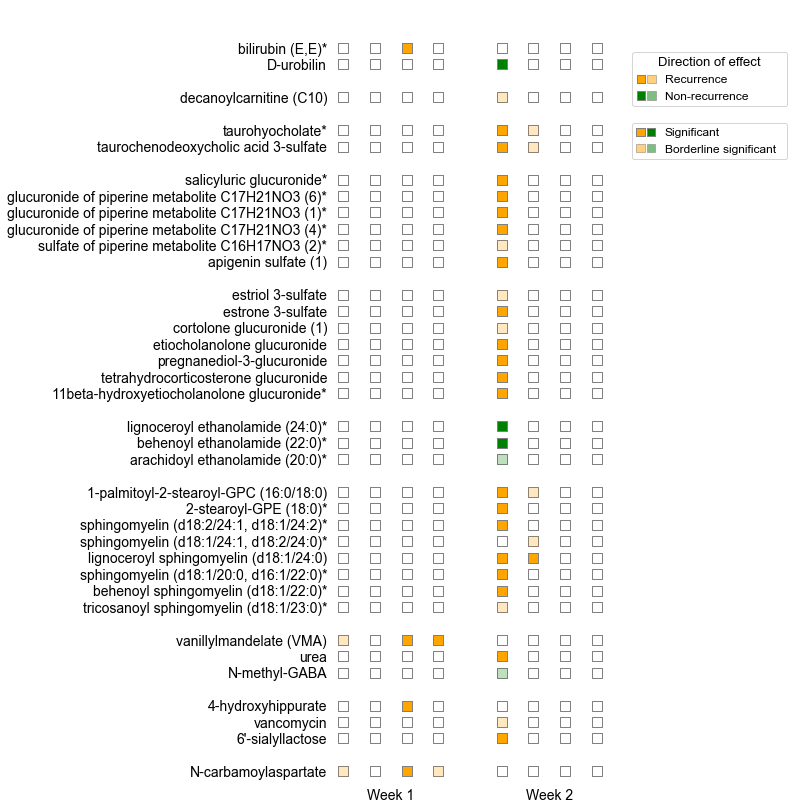

In [493]:

custom_order = np.flipud(custom_order_w_add_ons).tolist()
to_remove = list(set(custom_order) - set(all_metabs))
to_remove.remove('')
for val in to_remove:
    custom_order.remove(val)
    
const = 0
val = 0
for ii,c in enumerate(custom_order):
    if c == '':
        const += 1
    else:
        const = 0
    if const >= 2:
        custom_order.pop(ii - val)
        val += 1

fig, ax = plt.subplots(figsize = (5,(14/44)*len(custom_order)))
# fig.subplots_adjust(top = 10)
ls_plot = np.where(np.array(custom_order) != '')[0]
ax.scatter(np.concatenate([[0]*len(ls_plot),[5]*len(ls_plot)]), 
           list(ls_plot)*2, s = 85, color = 'white',edgecolors = 'gray', marker = 's')
ax.scatter(np.concatenate([[1]*len(ls_plot),[6]*len(ls_plot)]), 
           list(ls_plot)*2, s = 85, color = 'white',edgecolors = 'gray',marker='s')
ax.scatter(np.concatenate([[2]*len(ls_plot),[3]*len(ls_plot),[7]*len(ls_plot),[8]*len(ls_plot)]), 
           list(ls_plot)*4, s = 85, color = 'white',edgecolors = 'gray',marker='s')
ax.set_ylim(-0.85,len(custom_order) + 1.5)
ax.set_frame_on(False)
ax.tick_params('both', length=0, which='major')
ax_t = ax.secondary_xaxis('top')
ax_t.set_frame_on(False)
ax.tick_params('both', length=0)
ax.set_yticks(np.arange(len(custom_order)))
ax.set_yticklabels(custom_order, fontsize = 14)
ax_t.set_xticks([])

ax.set_xticks([1.5,6.5],  minor = False)
ax.set_xticklabels(['Week 1','Week 2'], minor = False, fontsize = 14)
# ax.xaxis.set_ticks_position('bottom')
# ax.set_xticklabels([])
# ax.set_ylabel('',labelpad=1000, loc = 'top')
# a1a = ax.scatter([],[],c='g',s=100, marker = 's', edgecolors = 'gray')
# a1b = ax.scatter([],[],c='g',s=100, marker = 's', edgecolors = 'gray', alpha = 0.5)
# a2a = ax.scatter([],[],c='orange',s=100, marker = 's', edgecolors = 'gray')
# a2b = ax.scatter([],[],c='orange',s=100, marker = 's', edgecolors = 'gray', alpha = 0.5)

h = [MulticolorPatch(['orange','orange'], ['s','s'], alphas = [1,0.5]), 
     MulticolorPatch(['g','g'], ['s','s'], alphas = [1,0.5])]
l = ['Recurrence', 'Non-recurrence          ']

leg1 = fig.legend(h, l, 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', 
                  bbox_to_anchor=(0.91, 0.71,0.5,0.2), fontsize = 13, prop={'size': 12},
                 title = 'Direction of effect', title_fontsize = 'large')

h = [MulticolorPatch(['orange','g'], ['s','s'], alphas = [1,1]), 
     MulticolorPatch(['orange','g'], ['s','s'], alphas = [0.5,0.5])]
l = ['Significant', 'Borderline significant  ']

leg1 = fig.legend(h, l, 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'right', 
                  bbox_to_anchor=(0.91, 0.65,0.5,0.2), fontsize = 13, prop={'size': 12})


for week, file in feats_fig5.items():
    if week != 0:
        print(week)
        lr_mets={}
        for out, res in file.items():
            for method, mets in res.items():
                if len(mets)==0:
                    continue
                if 'LR' in method: 
                    xval = (week-1)*5 + 2
                elif 'RF' in method:
                    xval = (week-1)*5 + 1
                elif 'cox' in method:
                    xval = (week-1)*5 + 3
                else:
                    xval = (week-1)*5 + 0
                if method.split('-')[0] not in lr_mets.keys():
                    lr_mets[method.split('-')[0]] = []
                for met in mets.index.values:
        #             try:
                    col = 'orange'
                    a = 0.25
                    if met not in custom_order:
                        print('ERROR: ' + met)
                        continue
                    yval = np.where(np.array(custom_order)==met)[0]

                    if 'LR' in method or 'RF' in method or 'cox' in method:
                        s = 100

                        if mets[met]<1:
                            col = 'g'
                        if met in pred_feats[method.split('-')[0]]:
                            a = 1
                        if met not in pred_feats and met in lr_mets[method.split('-')[0]]:
                            continue
                        else:
                            lr_mets[method.split('-')[0]].append(met)
                    else:
                        s = 100
                        if mets['Direction'].loc[met]=='Decreased Risk':
                            col = 'g'
                        if mets['BH corrected'].loc[met] <0.05:
                            a = 1
                    ax.scatter([xval], yval, s = s, color = col, marker = 's', alpha = a, edgecolors = 'gray')

fig.savefig(path_to_save + 'Fig5/fig5_75_interval.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=2)

In [ ]:
custom_order = ['Carbohydrate','Xenobiotics','Nucleotide','Lipid','Cofactors and Vitamins','Amino Acid']

dat, _ = get_data('metabs', dl, dtype = 'data', features = np.unique(all_feats))
met_order = []
for j,pathway in enumerate(custom_order):
    metabs = df_dendro.index.values[df_dendro['SUPER_PATHWAY']==pathway]
    metabs = list(np.unique(list(set(metabs).intersection(set(dat.columns.values)))))

    if len(metabs)>2:
        order = np.array(get_metab_clustermap(dat.loc[:,metabs], 'metabs'))
        metabs = list(np.array(metabs)[order])

    if j != 0:
        met_order.append('')
    met_order.extend(metabs)

slab = []
for i,r in enumerate(met_order):
    if '(' in r:
        r = r.split(' (')[0]
    r = r.replace('*','')
    r = r.replace('beta','\u03B2')
    if 'glucuronide of piperine' in r:
        if 'glucuronide of piperine' in met_order[i+1] and 'glucuronide of piperine' in met_order[i+2]:
            r = ' '
        if 'glucuronide of piperine' in met_order[i-1] and 'glucuronide of piperine' in met_order[i+1]:
            temp = r.split(' ')
            r = temp[0] + 's ' + temp[1] + '\n' + ' '.join(temp[2:4]) + '\n' + ' '.join(temp[4:])
        if 'glucuronide of piperine' in met_order[i-2] and 'glucuronide of piperine' in met_order[i-1]:
            r = ' '
    if 'sulfate of piperine' in r:
        temp = r.split(' ')
        r = '\n'+ ' '.join(temp[:3]) + '\n' + ' '.join(temp[3:])
            
    slab.append(r)

1.0
LR-0768.csv
2.0

cox2-0768.csv
3.0

ttest_metabs1.csv
0.0

2.0
RF-0774.csv
6.0

cox2-078.csv
8.0

ttest_metabs2.csv
5.0



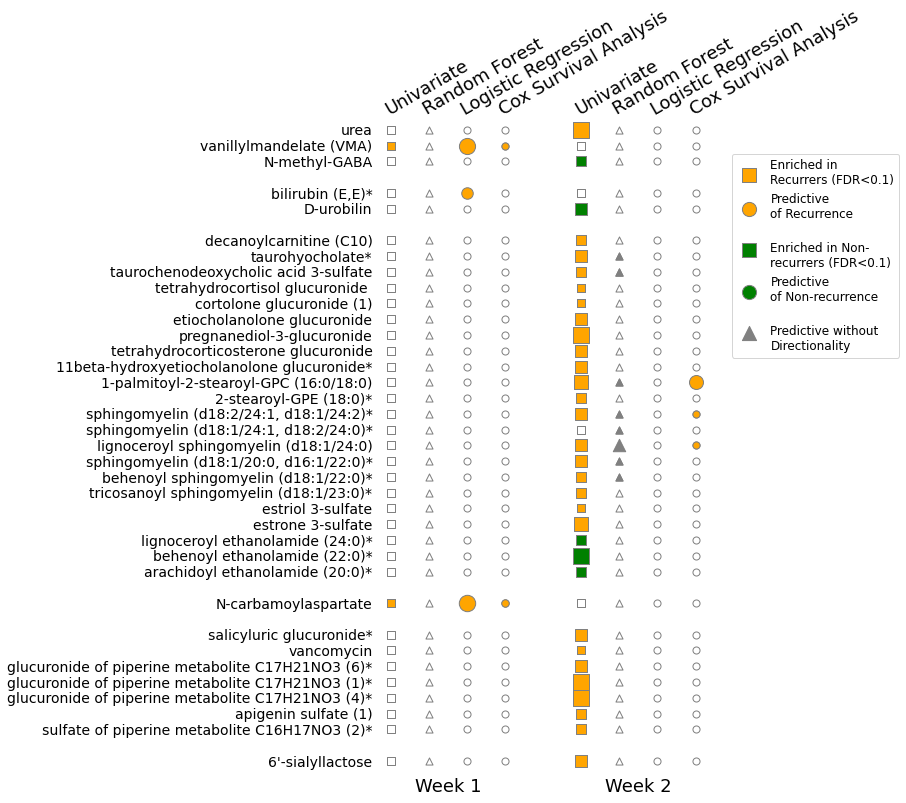

In [1102]:
fig, ax = plt.subplots(figsize = (6,12))
# fig.subplots_adjust(top = 10)
ls_plot = np.where(np.array(slab) != '')[0]
ax.scatter(np.concatenate([[0]*len(ls_plot),[5]*len(ls_plot)]), 
           list(ls_plot)*2, s = 50, color = 'white',edgecolors = 'gray', marker = 's')
ax.scatter(np.concatenate([[1]*len(ls_plot),[6]*len(ls_plot)]), 
           list(ls_plot)*2, s = 50, color = 'white',edgecolors = 'gray',marker='^')
ax.scatter(np.concatenate([[2]*len(ls_plot),[3]*len(ls_plot),[7]*len(ls_plot),[8]*len(ls_plot)]), 
           list(ls_plot)*4, s = 50, color = 'white',edgecolors = 'gray')
ax.set_ylim(-0.85,40.5)
ax.set_frame_on(False)
ax.tick_params('both', length=0, which='major')
ax_t = ax.secondary_xaxis('top')
ax_t.set_frame_on(False)
ax.tick_params('both', length=0)
ax.set_yticks(np.arange(len(slab)))
ax.set_yticklabels(met_order, fontsize = 14)
ax_t.set_xticks([0,1,2,3,5,6,7,8])
ax_t.tick_params('both', length=0)
ax_t.set_xticklabels(['Univariate','Random Forest','Logistic Regression','Cox Survival Analysis',
                    'Univariate','Random Forest','Logistic Regression','Cox Survival Analysis'], rotation = 30, 
                   ha='left',rotation_mode="anchor")
# ax.xaxis.set_ticks_position('top')

ax.set_xticks([1.5,6.5],  minor = False)
ax.set_xticklabels(['Week 1','Week 2'], minor = False)
# ax.xaxis.set_ticks_position('bottom')
# ax.set_xticklabels([])
# ax.set_ylabel('',labelpad=1000, loc = 'top')
a1a = ax.scatter([],[],c='g',s=200, marker = 's', edgecolors = 'gray')
a1b = ax.scatter([],[],c='g',s=200, edgecolors = 'gray')
a2a = ax.scatter([],[],c='orange',s=200, marker = 's', edgecolors = 'gray')
a2b = ax.scatter([],[],c='orange',s=200, edgecolors = 'gray')
a3 = ax.scatter([],[],c='gray',s=200, marker = '^', edgecolors = 'gray')
lgd = fig.legend([a2a,a2b,a1a,a1b,a3],['Enriched in\nRecurrers (FDR<0.1)','Predictive\nof Recurrence', 
          '\nEnriched in Non-\nrecurrers (FDR<0.1)','Predictive\nof Non-recurrence','\nPredictive without\nDirectionality'],
          bbox_to_anchor=(1.35, 0.85), fontsize = 12)
for week, res in feats_fig5.items():
    if week != 0:
        print(week)
        for method, mets in res.items():
            if len(mets)==0:
                continue
            if 'LR' in method: 
                xval = (week-1)*5 + 2
                m = 'o'
            elif 'RF' in method:
                xval = (week-1)*5 + 1
                m = '^'
            elif 'cox' in method:
                xval = (week-1)*5 + 3
                m = 'o'
            else:
                xval = (week-1)*5 + 0
                m = 's'
            for met in mets.index.values:
    #             try:
                if met not in met_order:
                    continue
    #             print(met)
                yval = np.where(np.array(met_order)==met)[0]
    #             print(xval)
    #             print(yval)
                if 'LR' in method or 'RF' in method or 'cox' in method:
                    s = 700*np.abs(np.log(mets[met]))
                    if s<50:
                        s = 50
                    if 'RF' in method:
                        c = 'gray'
                    else:
                        if mets[met]<1:
                            c = 'g'
                        else:
                            c = 'orange'
                else:
                    s = 70*np.abs(np.log10(mets['BH corrected'].loc[met]))
                    if mets['Direction'].loc[met]=='Increased Risk':
                        c = 'orange'
                    else:
                        c = 'g'

                ax.scatter([xval], yval, s = s, color = c, edgecolors = 'gray', marker = m)
            print(method)
            print(xval)
            print('')

#             except:
#                 import pdb; pdb.set
# fig.tight_layout()
# fig.subplots_adjust(top = 2)
# plt.autoscale()
fig.savefig(path_to_save + 'Fig5/fig5_2.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=.8)

In [ ]:
feats = ['billirubin (E,E)', 'D-urobilin','arachidoyl ethanolamide (20:0)', 'lignoceroyl ethanolamide (22:0)', 
         'N-methyl-GABA','N-carbamoylaspartate','lignoceroyl sphingomyelin (d18:1/24:0)','behenoyl sphingomyelin (d18:1/22:0)',
        'sphingomyelin (d18:1/20:0, d16:1/22:0)', 'sphingomyelin (d18:1/24:1, d18:2/24:0)', 
         'tricosanoyl sphingomyelin (d18:1/22:0)','1-palmitoyl-2-stearoyl-GPE (18:0)','decanoylcarnitine','vancomycin',
        'salicyluric glucuronide', 'glucuronide of piperine metabolite\nC17H21NO3 (1)','glucuronide of piperine metabolite\nC17H21NO3 (4)',
        'glucuronide of piperine metabolite\nC17H21NO3 (6)','etiocholanolone glucuronide','11\u03B2-hydroxyetiocholanolone\nglucuronide',
        'corotolone glucuronide','tetrahydrocorticosterone glucuronide',]

# Figure 2 - heatmaps

In [153]:
def get_data(key, dl, dtype='filtered_data', week = None, features = None):
    data = dl.keys[key][dtype]
    ix_keep = [ix for ix in data.index.values if ix.split('-')[1].isnumeric()]
    if week ==None:
        ix_keep = [ix for ix in ix_keep if float(ix.split('-')[1])<=2]
    else:
        ix_keep = [ix for ix in ix_keep if float(ix.split('-')[1])==week]
    
    data = data.loc[ix_keep]
    if features is not None:
        data = data[features]
    outcomes = dl.keys[key]['targets'].loc[ix_keep]
    return data, outcomes

In [154]:
ratios = {}
for key in 'metabs', '16s', 'scfa':
    data, _ = get_data(key, dl, dtype = 'filtered_data')
    total = data.shape[0]
    ratios[key] = {}
    for week in [0,1,2]:
        data, _ = get_data(key, dl, week = week, dtype = 'filtered_data')
        ratios[key][week] = (data.shape[0]/total)*14

In [155]:
def make_side_heatmap(key, rownames, path_to_save, plot_padj = True):
    df = {}
    for week in [0,1,2]:
        if key == '16s' and isinstance(week, list):
            continue
        if key == '16s':
            test = 'deseq2'
            pname = 'padj'
        else:
            test = 'ttest'
            pname = 'BH corrected'
        univ_anal = pd.read_csv(path_to_save + 'univariate_analysis/' + key + '/' +test + '_' + key + str(week) + 
                                '.csv', index_col = 0)
#         df[week] = univ_anal.loc[univ_anal[pname]<0.1]
        if plot_padj:
            data_to_plot = univ_anal.iloc[:,[-3,-1]]
        else:
            data_to_plot = univ_anal.iloc[:,-1:]
            
        not_present = list(set(rownames) - set(data_to_plot.index.values))
        for metab in not_present:
            if plot_padj:
                data_to_plot.loc[len(data_to_plot.index)] = [1,0]
            else:
                data_to_plot.loc[len(data_to_plot.index)] = [0]
            data_to_plot.index.values[-1] = metab
        
        df[week] = data_to_plot.loc[rownames]
        if len(rownames)==0:
            df[week] = data_to_plot
        
    return df
        

In [156]:
def get_metab_clustermap(data, key):
    x = data.T
    if key=='16s':
        dist_mat = scipy.spatial.distance.pdist(x, metric = 'braycurtis')
        dist_mat = scipy.spatial.distance.squareform(dist_mat)

    else:
        corr, p = st.spearmanr(x.T)
        if len(corr.shape)==0:
            corr = np.array([[1,corr],[corr,1]])
        dist_mat = (1 - corr)/2
        dist_mat = (dist_mat + dist_mat.T) / 2
        np.fill_diagonal(dist_mat,0)
        
    linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(dist_mat), method = 'average', 
                                              optimal_ordering = True)

    g = sns.clustermap(data.T, row_linkage = linkage, col_cluster = False, row_cluster = True,  
                   vmin = -4, vmax = 4, cmap=plt.get_cmap('bwr'))

    g.cax.set_visible(False)
    g.fig.set_visible(False)
    return g.dendrogram_row.reordered_ind

In [157]:
def get_pt_clustermap(data, outcomes, key):

    rgb_outcome = {'Recurrer':matplotlib.colors.to_rgba('r')[:-1], 'Non-recurrer': matplotlib.colors.to_rgba('g')[:-1]}
    # pt_outcome = dict(zip(np.unique(pts), generate_colormap(len(np.unique(pts)))))

    o_map = outcomes.map(rgb_outcome)
    df_colors = o_map
    x = data

    if key=='16s':
        dist_mat = scipy.spatial.distance.pdist(x, metric = 'braycurtis')
        dist_mat = scipy.spatial.distance.squareform(dist_mat)
    else:
        corr, p = st.spearmanr(x.T)
        dist_mat = (1 - corr)/2
        dist_mat = (dist_mat + dist_mat.T) / 2
        np.fill_diagonal(dist_mat,0)
        
    linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(dist_mat), method = 'average', 
                                              optimal_ordering = True)

    g = sns.clustermap(data.T, col_linkage = linkage, col_cluster = True, row_cluster = False, col_colors = df_colors, 
                   vmin = -4, vmax = 4, cmap=plt.get_cmap('bwr'))

    g.cax.set_visible(False)
    g.fig.set_visible(False)
    return g, rgb_outcome

In [226]:
def make_metab_dendrogram(df_dendro, data, fig, ax, custom_dict, skip_offset = .10, buffer = 0):

    ypts_S = [0]
    sub_path_S = []
    coords_S = []
    colors_S = []
    col_dict = {}

    ypts = [0]
    sub_path = []
    hcoords = []
    vcoords = []
    hcolors = []
    vcolors = []
    annotation = []
    order_dict = {}
    order_past = 0
    pathways = []
    y_add = 0
    for j,pathway in enumerate(custom_order):
        if isinstance(pathway, list):
            path = pathway[0]
        else:
            path = pathway
        if path in df_dendro['SUB_PATHWAY'].values:
            sup_or_sub = 'SUB_PATHWAY'
        elif path in df_dendro['SUPER_PATHWAY'].values:
            sup_or_sub = 'SUPER_PATHWAY'
        else:
            print(pathway)
            print('ERROR - NO PATHWAY')
            return None
        if isinstance(pathway, list):
            metabs = np.concatenate([df_dendro.index.values[df_dendro[sup_or_sub]==path] for path in pathway])
            pathway = '; '.join(pathway)
        else:
            metabs = df_dendro.index.values[df_dendro[sup_or_sub]==pathway]
        txt = pathway
        metabs = list(set(metabs).intersection(set(data.columns.values)))
        if len(metabs)==0:
            continue
        if len(pathway)>20:
            txt = txt[:20]
        if txt[-1] != 's':
            txt = txt + 's'
    #     sub_pathways = np.unique(df_dendro['SUB_PATHWAY'][df_dendro['SUPER_PATHWAY']==pathway])
        super_gp_size = len(metabs)
        y_start_sup = ypts_S[-1] + buffer
        y_end_sup = super_gp_size + y_start_sup
        y_mid_sup = super_gp_size/2 + y_start_sup
        print(y_mid_sup)
        xpt = 3

        hline_sup = [[xpt, y_mid_sup],[xpt-2, y_mid_sup]]
        vline_sup = [[xpt-2, y_end_sup],[xpt-2, y_start_sup]]
        hcoords.append(hline_sup)
        vcoords.append(vline_sup)
        hcolors.append('C' + str(j))
        vcolors.append('C' + str(j))
    #     vcolors.extend(['C' + str(j)]*2)
        if len(metabs)>1:
            order = np.array(get_metab_clustermap(data.loc[:,metabs], 'metabs'))
            order_dict[pathway] = np.array(metabs)[order]
        else:
            order_dict[pathway] = np.array(metabs)
        pathways.append(pathway)
#         sub_pathways = np.unique(df_dendro[sup_or_sub][df_dendro[sup_or_sub]==pathway])
        annotation.append(((xpt-0.1, y_mid_sup + 0.5),txt))

        ypts_S.append(y_end_sup)

    xyvals = np.concatenate(np.concatenate([hcoords, vcoords]))

    line_segments = LineCollection(hcoords, colors = hcolors)
    ax.add_collection(line_segments)
    ax.set_xlim(np.max(xyvals[:,0]),np.min(xyvals[:,0]))
    ax.set_ylim(np.min(xyvals[:,1]), np.max(xyvals[:,1]))

    line_segments_v = LineCollection(np.array(vcoords), colors = vcolors, linewidths = 5)
    ax.add_collection(line_segments_v)

#     for coord, val in annotation:
#         t = ax.annotate(val, coord)


    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    fig.tight_layout()
    return fig, ax, order_dict, pathways

In [217]:
def plot_heatmap(key, rownames, fig, ax_heat, ax_side, dl, figsize = 12*10,weeks = [0,1,2], 
                 dtype = 'data',
                 path_to_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/', 
                 cmap_heat = 'bwr', cmap_sig = 'PiYG'):

    df_side = make_side_heatmap(key, rownames, 
                                path_to_save,plot_padj = True)
    import matplotlib.colors as colors
    
    
#     if key == '16s':
#         dat = get_data(key, dtype = dtype)[0]
#         fin_seqs = list(set(seqs).intersection(set(dat.columns.values)))
    df_all = np.concatenate([df_side[i].iloc[:,0].values for i in df_side.keys()])
    df_all = df_all[~np.isnan(df_all)]
    for i,week in enumerate(weeks):
        d_week, outcomes = get_data(key, dl, week = week, dtype = dtype, features = rownames)
        if key == '16s':
            data_week = np.divide(d_week.T, np.sum(d_week, 1)).T
#             epsilon = get_epsilon(data_prop)
#             geom_means = np.exp(np.mean(np.log(data_prop + epsilon), 1))
#             temp = np.divide(data_prop.T, geom_means).T
#             epsilon = get_epsilon(temp)
#             transformed = np.log(temp + epsilon)
#             d_week = standardize(transformed)
        else:
            epsilon = get_epsilon(d_week)
            transformed = np.log(d_week + epsilon)
            d_week = standardize(transformed)
#         g, rgb_outcome = get_pt_clustermap(d_week, outcomes, key)
        outcome_ixs = np.concatenate([np.where(outcomes.values=='Recurrer')[0], 
                                      np.where(outcomes.values=='Non-recurrer')[0]])
    
        re_ixs = np.where(outcomes.values=='Recurrer')[0]
        cl_ixs = np.where(outcomes.values == 'Non-recurrer')[0]
        ix1 = len(np.where(outcomes.values=='Recurrer')[0])

        if len(rownames)==0:
            data = d_week.iloc[outcome_ixs,:]
        else:
            data = d_week.loc[:,rownames].iloc[outcome_ixs,:]
          
        data = data.T
        data.insert(len(re_ixs), 'zeros', -99*np.ones(data.shape[0]))
        outcome_locs = [ix1/2, 1 + ix1 + len(np.where(outcomes.values=='Non-recurrer')[0])/2]
        if i == 0:
            outcome_locs[0] = outcome_locs[0] - 2
            outcome_locs[1] = outcome_locs[1] + 2
#         top_heatmap = np.expand_dims(np.array([0]*len(re_ixs) + [2] + [1]*len(cl_ixs)),0)      
        if key != '16s':
            pos = ax_heat[i].imshow(data, cmap=plt.get_cmap(cmap_heat), 
                                   vmin = -4, vmax = 4, interpolation = 'nearest',aspect = 'auto');
        else:
            pos = ax_heat[i].imshow(data + 1, cmap=plt.get_cmap(cmap_heat), 
                                   interpolation = 'nearest',aspect = 'auto',
                                    norm = colors.LogNorm(vmin = 1, vmax = data.max().max()));
            
#         ax_heat[i].axvline(x=len(re_ixs)+0.5,ls='--')

        ax_heat[i].set_frame_on(False)
        ax_heat[i].axes.get_yaxis().set_visible(False)
#         ax_heat[i].axes.get_xaxis().set_ticks([])
    #     ax_metabs[i].axes.get_xaxis().set_visible(False)
        ax_heat[i].grid( False, axis='x' )
        if float(week)==0:
            ax_heat[i].set_xlabel('Pre-antibiotic \n Treatment')
        else:
            ax_heat[i].set_xlabel('Week ' + str(week))
        ax_heat[i].xaxis.set_label_position('bottom')
        
#         ax_heat[i].set_anchor('E')

#         ax_heat[i].xaxis.set_label_position('top')
    
        from matplotlib.colors import LinearSegmentedColormap
        outcomes = np.expand_dims(outcomes, 0)
#         cmap = LinearSegmentedColormap.from_list('r_nr', ['tab:blue','tab:cyan','w'], N=3)
#         top = ax_top[i].imshow(top_heatmap,cmap = cmap,
#                                  interpolation = 'nearest', aspect = 'auto')
#         ax_top[i].axes.get_xaxis().set_visible(False)
        
        ax_heat[i].set_xticks(outcome_locs)
        ax_heat[i].xaxis.tick_top()
        if i == 0:
            ax_heat[i].set_xticklabels(['Recurrer       ', 'Non-recurrer'], ha = 'center')
        else:
            ax_heat[i].set_xticklabels(['Recurrer  ', 'Non-recurrer'], ha = 'center')
        ax_heat[i].tick_params(axis=u'both', which=u'both',length=0)
        
#         ax_top[i].xaxis.set_label_position('top')
        
        colors2 = ['darkslategray','darkcyan']
        for xtick, color in zip(ax_top[i].get_xticklabels(), colors2):
            xtick.set_color(color)

        if 't-stat' in df_side[i].columns.values:
            df_side[i]['t-stat'] = df_side[i]['t-stat'].fillna(0)
        else:
            df_side[i].iloc[:,-1:] = df_side[i].iloc[:,-1:].fillna(0)
            
        df_side[i].iloc[:,0] = df_side[i].iloc[:,0].fillna(1)
            
        vmin = np.min(df_all)
        vmax = np.max(df_all)
        print(vmin)
#         if key == 'scfa':
#             vmin = 0.0002971510856079
#         vall = np.max([np.abs(vmin), np.abs(vmax)])
#         vmin, vmax = -vall, vall
#         print(df_side[i].iloc[:,:0])
#         print(vmin)
#         print('')
        vmin = 1e-4
        right = ax_side[i].imshow(df_side[i].iloc[:,0:1],interpolation = 'nearest', aspect = 'auto',
                                 vmin = vmin, vmax = 1, cmap = plt.get_cmap(cmap_sig),
                                  norm = colors.LogNorm(vmin = 1, vmax = data.max().max()))
#         ax_side[i].set_anchor('W')
        
        labels = df_side[i].iloc[:,-1].copy()
        labels[(df_side[i].iloc[:,-1]< 0)*(df_side[i].iloc[:,0]<=0.05)] = '\u2193'
        labels[(df_side[i].iloc[:,-1] >0)*(df_side[i].iloc[:,0]<=0.05)] = '\u2191'
        labels[df_side[i].iloc[:,-1] == 0] = ''
        labels[df_side[i].iloc[:,0]>0.05] = ''
        labels[np.isnan(df_side[i].iloc[:,-1])] = ''
        ax_side[i].set_yticks(np.arange(df_side[i].shape[0]))
        ax_side[i].set_yticklabels(labels)
        ax_side[i].tick_params(axis='y', which='major', pad=0.05, left = False, labelleft = False, labelright = True)
        ax_side[i].tick_params(axis=u'both', which=u'both',length=0)
        ax_side[i].yaxis.set_label_position('right')
        ax_side[i].axes.get_xaxis().set_visible(False)
        ax_side[i].set_frame_on(False)

    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.01)

#     from matplotlib.patches import Patch
#     handles = [Patch(facecolor=rgb_outcome[name]) for name in rgb_outcome]
#     legend_1 = ax_top[-1].legend(handles, rgb_outcome, 
#                              bbox_to_anchor=(1, 2), loc='upper left',prop={'size': figsize/12})
    return fig, ax_heat, ax_top, ax_side, right, pos

In [171]:
def set_font_sizes(figsize, ftype_dict = {'font': 8, 'axes_title': 16, 'ax5s_label': 12, 
                                          'xtick_label': 10, 'ytick_label': 10, 'legend': 10, 'figure_title': 18}):
    default_a = (6*8)/7
    if figsize == None:
        area = default_a
    else:
        area = figsize[0]*figsize[1]/((figsize[0] + figsize[1])/2)
    for ftype, factor in ftype_dict.items():
        size = factor*area/default_a
        if 'title' in ftype:
            plt.rc(ftype.split('_')[0], titlesize=size)
        elif 'label' in ftype:
            plt.rc(ftype.split('_')[0], labelsize=size)
        elif 'legend' in ftype:
            plt.rc(ftype.split('_')[0], fontsize=size)   
        else:
            plt.rc(ftype.split('_')[0], size=size)
        print(ftype + ': ' + str(size))
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [162]:
def lookup_by_names(tree, otu_dict, seq_to_otu, path_to_save, branch_len = 0.1):
    
    sub_gps_to_name = []
    for week in [0,1,2]:
        univ_anal = pd.read_csv(path_to_save + 'univariate_analysis/16s/deseq2_16s' + str(week) + 
                                '.csv', index_col = 0)
        otus = univ_anal.index.values[univ_anal['padj']<0.1]
        sub_gps_to_name.extend(otus)
    sub_gps_to_name = np.unique(sub_gps_to_name)
    otu_to_name = [seq_to_otu[seq] for seq in sub_gps_to_name if seq in seq_to_otu.keys()]
    
    names = {}
    otu_order = []
    for clade in tree.find_clades():
        if clade.branch_length:
            if clade.branch_length>branch_len:
                clade.branch_length = branch_len
        if clade.name:
            if clade.name not in otu_dict.keys():
                dropped = tree.prune(clade)
                continue
#             if clade.name in otu_to_name:
#                 clade.color = 'red'
            otu_order.append(clade.name)
#             if clade.name == 'ASV_83':
#                 clade.name = otu_dict[clade.name]['tax'] + ',\n' + clade.name.replace('_','')
            if isinstance(otu_dict[clade.name]['tax'], str):
                if ' ' in otu_dict[clade.name]['tax']:
                    clade.name = '*' + otu_dict[clade.name]['tax'].replace(
                        '_',' ') + ', ' + clade.name.replace('_',' ')
                else:
                    clade.name = '**' + otu_dict[clade.name]['tax'].replace(
                        '_',' ') + ', ' + clade.name.replace('_',' ')
            else:
                clade.name= ' '.join(list(otu_dict[clade.name]['tax'].dropna())[5:]).replace(
                    '_','') + ', ' + clade.name.replace('_',' ')
            
            if clade.name == '**, ASV 89' or clade.name == '**, ASV 204':
                clade.name = '***Lachnospiraceae' + clade.name.split('**')[-1]
            if clade.name == '**, ASV 132':
                clade.name = '***Ruminococcaceae' + clade.name.split('**')[-1]
            
            names[clade] = clade.name
            
    return names

In [163]:
def to_distance_matrix(tree):
    allclades = list(tree.find_clades(order="level"))
    lookup = {}
    for i, elem in enumerate(allclades):
        lookup[elem] = i
    distmat = {}
    clade_names = []
    for parent in tree.find_clades():
        if parent.name:
            for child in tree.find_clades():
                if child.name:
                    if child.name.split(', ')[-1] not in distmat.keys():
                        distmat[child.name.split(', ')[-1]] = {}
                    if parent.name.split(', ')[-1] not in distmat.keys():
                        distmat[parent.name.split(', ')[-1]] = {}

                    distmat[parent.name.split(', ')[-1]][child.name.split(', ')[-1]] = tree.distance(parent, child)
                    distmat[child.name.split(', ')[-1]][parent.name.split(', ')[-1]] = tree.distance(parent, child)

    return pd.DataFrame(distmat)

# Create heatmaps with all important and/or mentioned metabolites/ASVs

In [164]:
import matplotlib as mpl
mpl.rc('font', **{'family' : 'sans-serif', 'sans-serif' : ['Myriad Pro']})
mpl.rcParams['pdf.fonttype'] = 42

In [165]:
path_univariate = path_to_save + 'univariate_analysis/'

feats_dict_sm = {}
# feats_dict_labels = {}
for dtype in ['16s','metabs']:
    feats = []
    imp_feats = []
    print(dtype)
    univariate = path_to_save + 'univariate_analysis/'
    for file in os.listdir(univariate + dtype):
        if '.csv' not in file or 'ecurrer' in file:
            continue
        if dtype == '16s' and 'deseq2' not in file:
            continue
        if dtype == 'metabs' and 'ttest' not in file:
            continue
        pvals = pd.read_csv(path_univariate + dtype + '/' + file, index_col = [0])
        if 'padj' in pvals.columns.values:
            pa = 'padj'
        else:
            pa = 'BH corrected'
        p_imp = pvals.index.values[pvals[pa]<=0.05]
        imp_feats.extend(p_imp)

    feats_dict_sm[dtype] = np.unique(imp_feats)
    print(len(np.unique(imp_feats)))
    print('')

16s
39

metabs
23



In [ ]:
# Export filtered taxa names to make tree with only query reads
taxa_labels = pd.read_csv(path_to_save + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

for i,seq in enumerate(feats_dict['16s']):
    if i ==0:
        wa = 'w'
    else:
        wa = 'a'
    
    f = open("phylo_placement_filt_01/data/asvs_to_place.txt", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq+ '\n')
    f.close()
    
    
    f = open("phylo_placement_filt_01/data/asvs_to_place.fa", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq + '\n')
    f.close()

In [1078]:
# Export filtered taxa names to make tree with only query reads
taxa_labels = pd.read_csv(path_to_save + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

for i,seq in enumerate(feats_dict_sm['16s']):
    if i ==0:
        wa = 'w'
    else:
        wa = 'a'
    
    f = open("phylo_placement_filt_005/data/asvs_to_place.txt", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq+ '\n')
    f.close()
    
    
    f = open("phylo_placement_filt_005/data/asvs_to_place.fa", wa)
    f.writelines('>' + taxa_labels.loc[seq]['labels'] + '\n' + seq + '\n')
    f.close()

In [167]:
def get_rownames(rownames):
    slab = []
    letter_len = 30
    for r in rownames:
        if '(' in r:
            r = r.split(' (')[0]
        r = r.replace('*','')
        r = r.replace('beta','\u03B2')
        xr = r.split('\n')
        while any([len(xxr)>letter_len for xxr in xr]):
            if ' ' in r and '\n' not in r:
                tmp_spl = r.split(' ')
                out = []
                for tmp in tmp_spl:
                    if len(tmp.split('\n')[-1])>=int(letter_len/2):
                        out.append(tmp + '\n')
                    else:
                        out.append(tmp + ' ')
                rtemp  = ''.join(out)
                if rtemp[-1]==' ':
                    rtemp = rtemp[:-1]
                xr = r.split('\n')
                if rtemp != r:
                    r = rtemp
                    continue
            if '-' in r and '-\n' not in r:
                tmp_spl = r.split('-')
                out = []
                for tmp in tmp_spl[:-1]:
                    if len(tmp.split('\n')[-1])>=int(letter_len/2):
                        out.append(tmp + '-\n')
                    else:
                        out.append(tmp + '-')
                out.append(tmp_spl[-1])
                rtemp  = ''.join(out)
                xr = r.split('\n')
                if rtemp != r:
                    r = rtemp
                    continue
            rr = r.split('\n')
            rout = []
            for ii,ri in enumerate(rr):
                if len(ri)>=letter_len:
                    ri = ri[:int(len(ri)/2)] + '-\n' + ri[int(len(ri)/2):]
                if ii != len(rr):
                    rout.append(ri + '\n')
                else:
                    rout.append(ri)
            r = ''.join(rout)
            xr = r.split('\n')
        r = r.replace('\n\n','')
        if r[-1] == '\n':
            r = r[:-1]
        slab.append(r)
    return slab

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0
3.72658536335234e-30
3.72658536335234e-30
3.72658536335234e-30


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launch

font: 4.5
font: 8.0


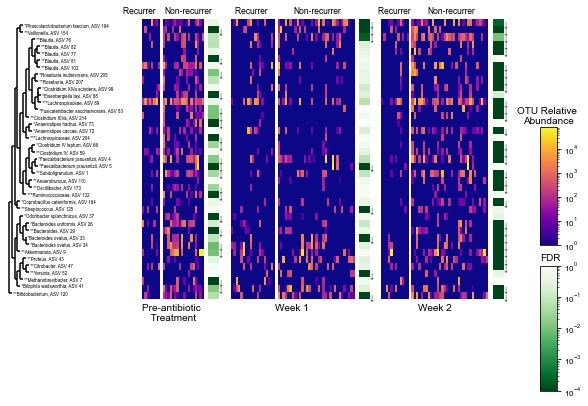

In [260]:
fig, ax = plt.subplots(1,10, gridspec_kw = {'width_ratios':[2,4,ratios['16s'][0],0.5,0.15,
                                                           ratios['16s'][1],0.5,0.15,ratios['16s'][2],0.5]}, 
                       figsize = (7.5,4.6875),
                      constrained_layout = False)

set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})

ax_otus = ax[[2,5,8]]
ax_phylo = ax[0]
ax_side = ax[[3,6,9]]
ax_inv_bw = ax[[1,4,7]]

for axx in ax_inv_bw:
    axx.set_visible(False)

path = 'phylo_placement_filt_005/'
with open(path + 'data/asvs_to_place.txt') as file:  
    data = file.read().splitlines()

otus = data[::2]
seqs = data[1::2]

# dat = get_data('16s', dtype = 'filtered_data')[0]
# seqs = list(set(seqs).intersection(set(dat.columns.values)))

taxonomy = 'inputs/tax_dat.csv'
taxdat_silva = pd.read_csv('inputs/dada2-taxonomy-silva.csv')
taxdat_rdp = pd.read_csv('inputs/dada2-taxonomy-rdp.csv')
taxdat = pd.read_csv(taxonomy, index_col = [0])

otu_dict = {}
for i, otu in enumerate(otus):
    if i >= len(seqs):
        break
    otu_dict[otu.split('>')[1]]={}
    otu_dict[otu.split('>')[1]]['seq'] = seqs[i]
#     otu_dict[otu.split('>')[1]]['tax'] = taxdat['genus_species'].loc[seqs[i]]
    
    otu_dict[otu.split('>')[1]]['tax'] = ' '.join(taxdat_rdp[seqs[i]][-2:].dropna())
#     otu_dict[otu.split('>')[1]]['tax'] = ''

seq_to_otu = {seq['seq']: otu for otu, seq in otu_dict.items()}
tree = Phylo.read(path + 'output/newick_tree_query_reads.nhx','newick')
clades = tree.get_terminals(order = 'preorder')
otu_order = [c.name for c in clades]
names = lookup_by_names(tree, otu_dict, seq_to_otu, path_to_save, branch_len = 0.01)

seq_order = [otu_dict[od]['seq'] for od in otu_order]
fig, ax_otus, ax_side, ax_top, right, pos = plot_heatmap('16s', seq_order, fig, ax_otus, 
                                                         ax_side, dl,dtype = 'data', cmap_heat = 'plasma', 
                                                         cmap_sig = 'Greens_r')

# ax_otus[0].axes.get_yaxis().set_visible(True)
# ax_otus[0].set_yticks(np.arange(len(seq_order)))
# ax_otus[0].set_yticklabels([otu_dict[otu]['tax'] for otu in otu_order], fontsize = 10)
                      
ax_phylo.set_frame_on(False)
ax_phylo.axes.get_yaxis().set_visible(False)
ax_phylo.axes.get_xaxis().set_visible(False)
set_font_sizes(None, {'font': 4.5})
Phylo.draw(tree, axes = ax_phylo,do_show=False)

set_font_sizes(None, {'font': 8})
arr_x = 0.96
arr_y = 0.08
cbaxes = fig.add_axes([arr_x + .08, -.17, 0.032, 0.37]) 
cbaxes.set_xlabel('FDR', labelpad = 5, loc = 'left')
cb = fig.colorbar(right, cax = cbaxes)
# cbaxes.set_yticklabels([r'$10^{-24}$',r'$10^{-18}$',r'$10^{-12}$',r'$10^{-6}$','1'])
cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x + 0.08, 0.26, 0.032, 0.35]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_xlabel('OTU Relative \nAbundance', loc = 'center')
# cbaxes2.set_yticklabels([0,10,r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
cbaxes2.xaxis.set_label_position('top')


# star = mlines.Line2D([], [], color='black', marker='$*$', linestyle='None',
#                           markersize=7.5, label='Species')
# starstar = mlines.Line2D([], [], color='black', marker='$*$', linestyle='None',
#                           markersize=10, label='Genus')
# starstarstar = mlines.Line2D([], [], color='black', marker='$**$', linestyle='None',
#                           markersize=14, label='Family')
# fig.legend(handles=[starstarstar, starstar], loc = 'upper right', bbox_to_anchor = (1.09, 0.96))

fig.savefig(path_to_save + 'Fig2/otus_005.pdf',bbox_inches='tight')

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0
0.5
1.5
3.0
6.5
11.0
14.0
16.0
17.5
20.0
22.5
0.0002971510856079
0.0002971510856079


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launch

0.0002971510856079
font: 4.5
font: 8.0


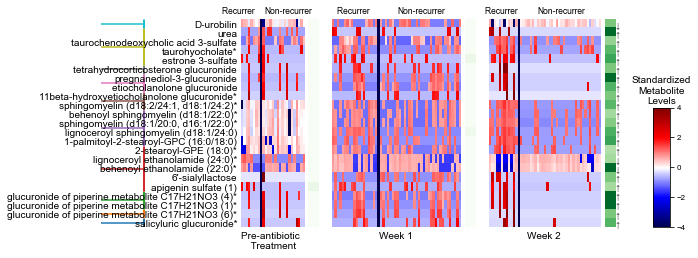

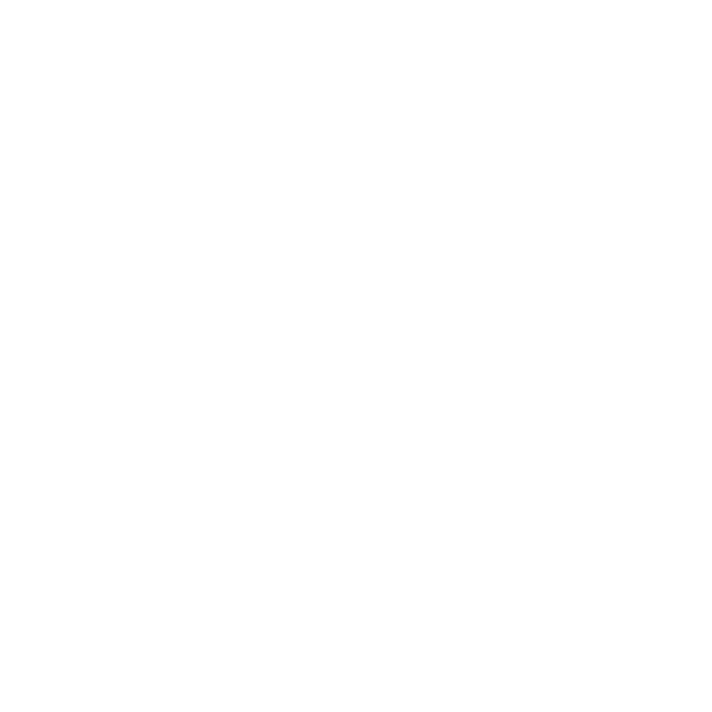

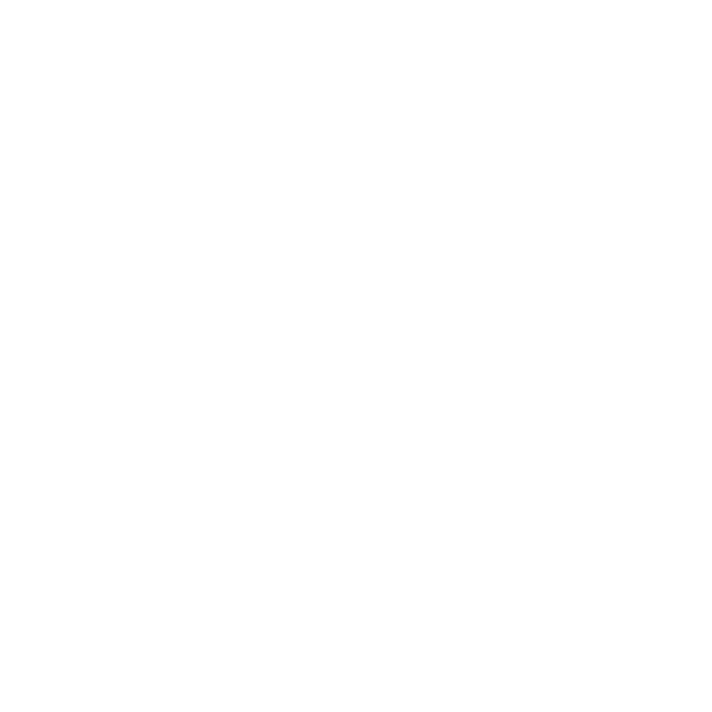

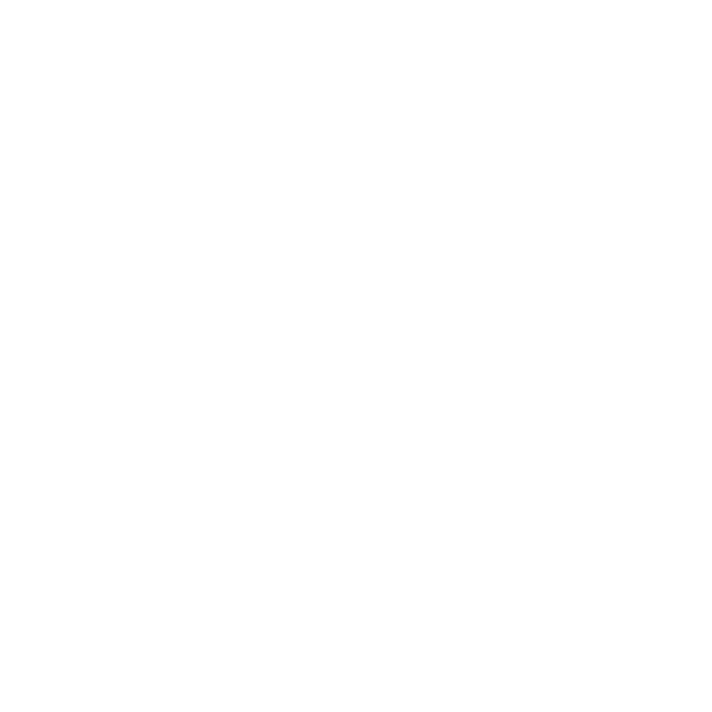

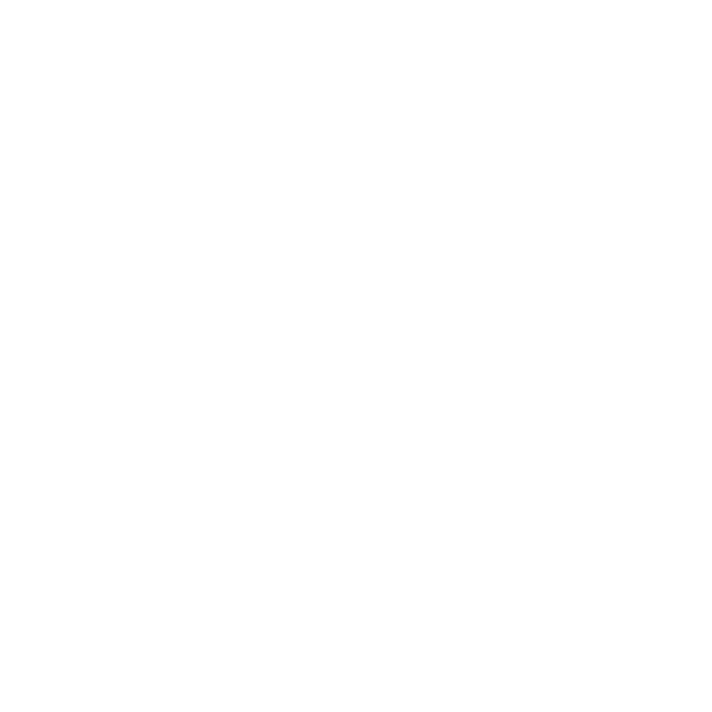

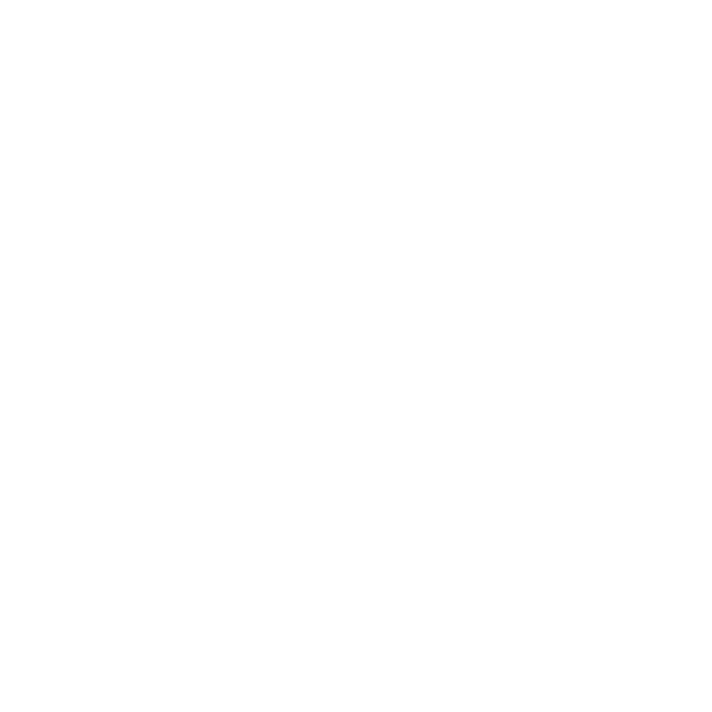

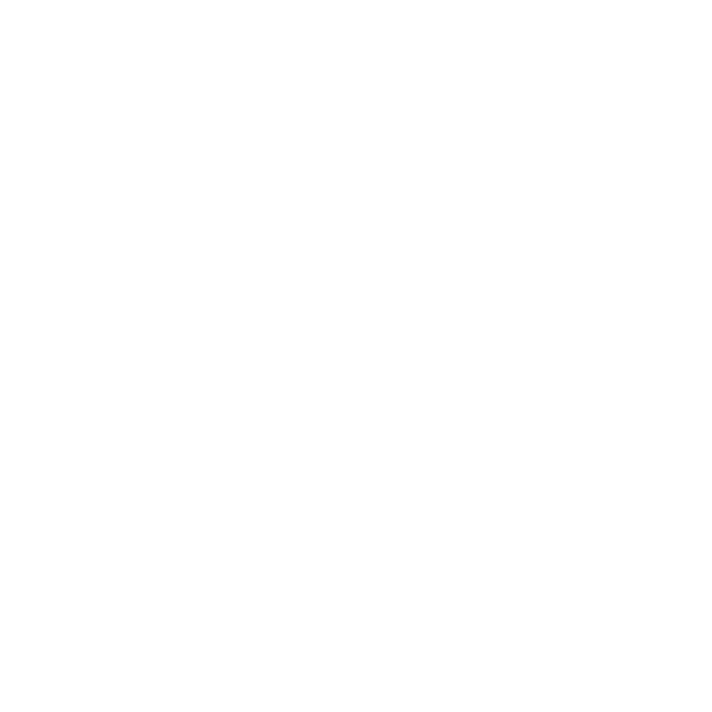

In [259]:
fig, ax = plt.subplots(1,10, gridspec_kw = {'width_ratios':[2,4,ratios['metabs'][0],0.5,0.15,
                                                           ratios['metabs'][1],0.5,0.15,ratios['metabs'][2],0.5]}, 
                       figsize = (7.5,3.6875),
                      constrained_layout = False)

set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})

# ax_metabs = ax[0,[1,3,5]]
# ax_dendro = ax[0,0]
# ax_top = ax[1,[1,3,5]]
# ax_side = ax[0,[2,4,6]]
# ax_inv = ax[1,[0,2,4,6]]

ax_metabs = ax[[2,5,8]]
ax_dendro = ax[0]
ax_side = ax[[3,6,9]]
ax_inv = ax[[0,1,3,6,9]]
ax_inv_bw = ax[[1,4,7]]

for axx in ax_inv_bw:
    axx.set_visible(False)


weeks = [0,1,2]

custom_order = ['Hemoglobin and Porphyrin Metabolism','Urea cycle; Arginine and Proline Metabolism',
                'Secondary Bile Acid Metabolism',
                ['Progestin Steroids','Estrogenic Steroids','Androgenic Steroids','Corticosteroids'],
                'Sphingomyelins',['Phosphatidylcholine (PC)','Lysophospholipid'],
                'Endocannabinoid','Carbohydrate','Food Component/Plant',['Drug - Antibiotic','Drug - Analgesics, Anesthetics']]
# custom_order = np.flip(custom_order)

col_mat_df = dl.col_mat_mets
col_mat_sorted = col_mat_df.sort_values(by = ['SUPER_PATHWAY', 'SUB_PATHWAY'])
biochem_sorted = col_mat_sorted.index.values
df_dendro = col_mat_sorted[['SUPER_PATHWAY','SUB_PATHWAY']].astype('category')

# df_dendro = df_dendro.replace('Partially Characterized Molecules','Partially \nCharacterized \nMolecules')
# df_dendro = df_dendro.replace('Cofactors and Vitamins', 'Cofactors \nand \nVitamins')

dat, _ = get_data('metabs', dl, dtype = 'data', features = feats_dict_sm['metabs'])

fig, ax_dendro, order_dict, pathways = make_metab_dendrogram(df_dendro, dat, fig, ax_dendro, custom_order)
rownames = np.concatenate([order_dict[path] for path in pathways])
# rownames = np.flip(rownames)

# rownames = dat.columns.values
fig, ax_metabs, ax_side, ax_top, right, pos = plot_heatmap('metabs', rownames, fig, ax_metabs, ax_side, dl,
                                                          cmap_heat = 'seismic', cmap_sig = 'Greens_r')
# df_side = make_side_heatmap('metabs', rownames, fig, ax_side_strip, 
#                             path_to_save, colormap = 'PRGn', plot_padj = True)

ax_metabs[0].axes.get_yaxis().set_visible(True)
set_font_sizes(None, {'font': 4.5})
ax_metabs[0].set_yticks(np.arange(len(rownames)))

# slab = get_rownames(rownames)
ax_metabs[0].set_yticklabels(rownames, fontsize = 10)
ax_metabs[0].tick_params('both', length=0, which='major')

ax_dendro.set_frame_on(False)
ax_dendro.axes.get_xaxis().set_visible(False)
ax_dendro.axes.get_yaxis().set_visible(False)

set_font_sizes(None, {'font': 8})
arr_x = 0.96
arr_y = 0.08
# cbaxes = fig.add_axes([arr_x + .08, -.2, 0.04, 0.45]) 
# cbaxes.set_xlabel('FDR', labelpad = 5, loc = 'left')
# cb = fig.colorbar(right, cax = cbaxes)
# # cbaxes.set_yticklabels([r'$10^{-24}$',r'$10^{-18}$',r'$10^{-12}$',r'$10^{-6}$','1'])
# cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x + .081, 0.13, 0.032, 0.45]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_xlabel('Standardized\nMetabolite\nLevels', loc = 'center')
# cbaxes2.set_yticklabels([0,10,r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'])
cbaxes2.xaxis.set_label_position('top')

fig.savefig(path_to_save + 'Fig2/metabs_sm_005.pdf',bbox_inches='tight')

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0
0.0674879133753477
0.0674879133753477
0.0674879133753477
font: 11.666666666666668
ytick_label: 9.722222222222223


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launch

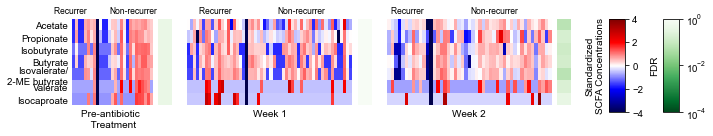

In [265]:
fig, ax = plt.subplots(1,8, gridspec_kw = {'width_ratios':[ratios['scfa'][0],0.5,0.15,
                                                           ratios['scfa'][1],0.5,0.15,ratios['scfa'][1],0.5]}, 
                       figsize = (7.5,2),
                      constrained_layout = False)
set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})
ax_scfa = ax[[0,3,6]]
ax_side = ax[[1,4,7]]
ax_inv_bw = ax[[2,5]]
    
for axx in ax_inv_bw:
    axx.set_visible(False)

dat, outcomes = get_data('scfa', dl, dtype = 'data')
rownames = dat.columns.values[:-2]
fig, ax_scfa, ax_side, ax_top, right, pos = plot_heatmap('scfa', rownames, fig, ax_scfa, ax_side, dl,
                                                         dtype = 'data', 
                                            figsize = 8*3.25, cmap_heat = 'seismic', cmap_sig = 'Greens_r')

ax_scfa[0].axes.get_yaxis().set_visible(True)
ax_scfa[0].set_yticks(np.arange(len(rownames)))
ax_scfa[0].set_yticklabels([dd.replace("/","/\n") for dd in rownames])
ax_scfa[0].tick_params(axis = 'y', length = 0)

arr_y = 0.19
arr_x = 1.05
set_font_sizes((10,5), {'font': 12, 'ytick_label': 10})
cbaxes = fig.add_axes([arr_x + 0.10, arr_y, 0.03, 0.65]) 
cb = fig.colorbar(right, cax = cbaxes)
cbaxes.set_ylabel('FDR')
cbaxes.yaxis.set_label_position("left")
# cbaxes.set_yticklabels(["$10^{-1}$","1"])
cbaxes.xaxis.set_label_position('top')

cbaxes2 = fig.add_axes([arr_x, arr_y, 0.03, 0.65]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_ylabel('Standardized\nSCFA Concentrations')
cbaxes2.yaxis.set_label_position("left")
# cbaxes2.set_yticklabels(["","-2","0","2",""])
cbaxes2.xaxis.set_label_position('top')
# cbaxes2.yaxis.tick_left()
fig.savefig(path_to_save + 'supplemental_figures/scfa.pdf',bbox_inches='tight')

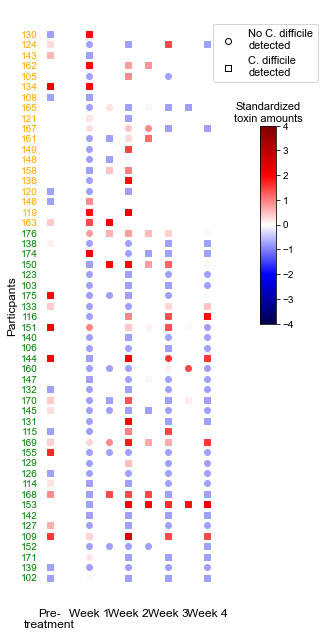

In [564]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=((11/53)*15, 11))

cmap = cm.get_cmap('seismic', 512)
tox_dat = dl.keys['toxin']['data']
toxin_flt = [float(x.split('-')[1]) for x in tox_dat.index.values]
ix_keep = np.where(np.array(toxin_flt)<=4)[0]
tox_dat = tox_dat.iloc[ix_keep,:]
outcomes = dl.keys['toxin']['targets_by_pt']
sort_outcome = np.argsort(outcomes.values)
out_sorted = outcomes.iloc[sort_outcome]

toxin_amts = tox_dat['ng/g Total toxinB in stool']
tox_log = np.log(toxin_amts + get_epsilon(toxin_amts))
tox_std = (tox_log - np.mean(tox_log))/np.std(tox_log)
tox_cmap = (tox_std - np.min(tox_std))/np.max((tox_std - np.min(tox_std)))
toxin_pts = [x.split('-')[0] for x in tox_dat.index.values]
toxin_tmpts = [x.split('-')[1] for x in tox_dat.index.values]

ax.set_yticks(np.arange(len(np.unique(toxin_pts))))
ax.set_yticklabels(out_sorted.index.values, fontsize = 10)
ax.set_xticks(np.arange(9))
ax.set_xticklabels(['Pre-\ntreatment','','Week 1','','Week 2','','Week 3','','Week 4'], fontsize = 12)
rows_vec = []
rows_vec = -1*np.ones((len(np.unique(toxin_pts)),18))
pts = []
markers = ['o','s']
for pt in out_sorted.index.values:
    loc = np.where(out_sorted.index.values==pt)[0]
    ixs = np.where(np.array(toxin_pts) == pt)[0]
    tmpts = (np.array(toxin_tmpts)[ixs]).astype('float')
    tmpts = (tmpts*2).astype(int)
    pts.append(pt)
    for ii, ix in enumerate(ixs):
        ax.scatter(tmpts[ii], loc, c = tox_std.iloc[ix], marker = markers[tox_dat['C diff isolate'].iloc[ix]],
                  cmap = cm.get_cmap('seismic', 512), vmin = -4, vmax = 4)
        
        if out_sorted[pt]=='Recurrer':
            ax.get_yticklabels()[loc[0]].set_color('orange')
        else:
            ax.get_yticklabels()[loc[0]].set_color('green')
            
ax.set_frame_on(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_ylabel('Particpants', fontsize = 12)

no = ax.scatter([],[],c = 'white', edgecolors = 'black', marker = 'o')
yes = ax.scatter([],[],c='white', edgecolors = 'black', marker = 's')
# leg_ax = fig.add_axes([0.9, 0.75, 0.2, 0.1])
# leg_ax.set_visible(False)
ax.legend([no,yes],['No C. difficile\ndetected','C. difficile\ndetected'], bbox_to_anchor=(1.12, 0.48, 0.5, 0.5),
         fontsize = 11)


cbaxes = fig.add_axes([1.1, 0.48, 0.07, 0.25]) 
fig.colorbar(cm.ScalarMappable(cmap=cmap, norm = matplotlib.colors.Normalize(vmin = -4,
                                                                            vmax = 4)), 
             ax=ax, cax = cbaxes)
cbaxes.set_xlabel('Standardized\ntoxin amounts', fontsize = 11)
cbaxes.xaxis.set_label_position('top')
# ax.legend()
fig.savefig(path_to_save + 'supplemental_figures/toxin.pdf',bbox_inches='tight')

font: 10.0
axes_title: 10.0
axes_label: 10.0
xtick_label: 8.5
ytick_label: 8.0
legend: 10.0
figure_title: 12.0
-0.9755876692913444


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


TypeError: '<' not supported between instances of 'str' and 'int'

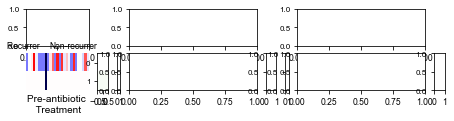

In [269]:
from matplotlib import colors
fig, ax = plt.subplots(2,8, gridspec_kw = {'width_ratios':[ratios['scfa'][0],0.5,0.15,
                                                           ratios['scfa'][1],0.5,0.15,ratios['scfa'][1],0.5], 
                                           'height_ratios': [1,1]}, 
                       figsize = (7.5,1.5),
                      constrained_layout = False)
set_font_sizes(None, {'font': 10, 'axes_title': 10, 'axes_label': 10, 
                                          'xtick_label': 8.5, 'ytick_label': 8, 
                         'legend': 10, 'figure_title': 12})
ax_scfa = ax[1,[0,3,6]]
ax_top2 = ax[0,[0,3,6]]
ax_side = ax[1,[1,4,7]]
ax_inv = ax[0:1,[1,4,7]]
ax_inv_bw = ax[0:1, [2,5]]

for axx in ax_inv:
    for axxx in axx:
        axxx.set_visible(False)
    
for axx in ax_inv_bw:
    for axxx in axx:
        axxx.set_visible(False)


dat, outcomes = get_data('toxin', dl,dtype = 'data')
rownames = dat.columns.values
fig, ax_scfa, ax_side, ax_top, right, pos = plot_heatmap('toxin', rownames, fig, ax_scfa, ax_side, dl,
                                                         dtype = 'data', 
                                            figsize = 8*6, cmap_heat = 'seismic', cmap_sig = 'Greens_r')

cmap = colors.ListedColormap(['gray', 'orange'])
for i,week in enumerate([0,1,2]):
    d_week, outcomes = get_data('toxin', dl,week = week, dtype = 'data', features = dat.columns.values[-2:])
    outcome_ixs = np.concatenate([np.where(outcomes.values=='Recurrer')[0], 
                                  np.where(outcomes.values=='Non-recurrer')[0]])
    d_week = d_week.iloc[outcome_ixs]
    ax_top2[i].imshow(d_week.T, cmap = cmap,interpolation = 'nearest',aspect = 'auto')
    ax_top2[i].set_frame_on(False)
    ax_top2[i].axes.get_yaxis().set_visible(False)
    ax_top2[i].axes.get_xaxis().set_ticks([])
#     ax_metabs[i].axes.get_xaxis().set_visible(False)
    ax_top2[i].grid( False, axis='x' )
    
    

ax_scfa[0].axes.get_yaxis().set_visible(True)
ax_scfa[0].set_yticks(np.arange(len(rownames)))
ax_scfa[0].set_yticklabels(["Avg interpolated \n toxin B (ng/mL)","Total toxin B \n in stool (ng/g)"])
ax_scfa[0].tick_params(axis = 'y', length = 0)

ax_top2[0].axes.get_yaxis().set_visible(True)
ax_top2[0].set_yticks(np.arange(len(rownames)))
ax_top2[0].set_yticklabels(["Toxin detected", "C. difficile isolate \n detected"])
ax_top2[0].tick_params(axis = 'y', length = 0)

arr_y = 0.13
arr_x = 1.01
set_font_sizes((18,5), {'font': 12, 'ytick_label': 14})
cbaxes = fig.add_axes([arr_x + 0.11, arr_y, 0.03, 0.6]) 
cb = fig.colorbar(right, cax = cbaxes)
cbaxes.set_ylabel('Effect size')
cbaxes.yaxis.set_label_position("right")
cbaxes.set_yticklabels(["-2","0","2"])
cbaxes.xaxis.set_label_position('top')
cbaxes.yaxis.tick_left()

cbaxes2 = fig.add_axes([arr_x, arr_y, 0.03, 0.6]) 
cb2 = fig.colorbar(pos, cax = cbaxes2)
cbaxes2.set_ylabel('Standardized toxin\n amounts')
cbaxes2.yaxis.set_label_position("right")
cbaxes2.set_yticklabels(["","-2","0","2",""])
cbaxes2.xaxis.set_label_position('top')
# cbaxes2.tick_params('y', left = True)
cbaxes2.yaxis.tick_left()

star = mlines.Line2D([], [], color='gray', marker='s', linestyle='None',
                          markersize=15, label='Not detected')
starstar = mlines.Line2D([], [], color='orange', marker='s', linestyle='None',
                          markersize=15, label='Detected')
fig.legend(handles=[starstar, star], loc = 'upper right', bbox_to_anchor = (1.15, 0.935), fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.01)
fig.savefig(path_to_save + 'supplementary_figures/toxin.pdf',bbox_inches='tight')